# Regularization - How to get a decent architecture?

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
print(pd.__version__)

0.23.3


In [5]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.9.0


In [6]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [7]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [1]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26800  100 26800    0     0  90235      0 --:--:-- --:--:-- --:--:-- 90235


In [9]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [11]:
df.head()

,max speed,age,thousand miles per year
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [12]:
df.describe()

,max speed,age,thousand miles per year
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000
std,17.604333,17.191727,15.463152
min,68.000000,9.000000,-21.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,102.000000,84.000000


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [126]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
        
def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

In [17]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We have several means of regularization for neural networks and we use a combination of them as described below.
- reduce capacity of model
- dropout
- batch normalization
- change activation to relu for faster training
- reduce amount of training cycles

### An experimental approach:
- keep adding regularization to make test and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have one too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data

In [31]:
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

dropout = 0.6
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(100, name='hidden1', input_dim=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(100, name='hidden2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               300       
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
activation_5 (Activation)    (None, 100)               0         
__________

In [32]:
# only if you are running this locally

# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [33]:
BATCH_SIZE=1000
EPOCHS = 4000

# only if you are running this locally
# !rm -rf ./tf_log
# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/4000
720/720 [==============================] - 1s 1ms/step - loss: 1.8375 - acc: 0.3236 - val_loss: 10.7272 - val_acc: 0.3333
Epoch 2/4000
720/720 [==============================] - 0s 20us/step - loss: 2.0211 - acc: 0.3000 - val_loss: 10.5301 - val_acc: 0.3333
Epoch 3/4000
720/720 [==============================] - 0s 15us/step - loss: 1.8235 - acc: 0.3278 - val_loss: 10.0338 - val_acc: 0.3333
Epoch 4/4000
720/720 [==============================] - 0s 15us/step - loss: 1.8627 - acc: 0.3569 - val_loss: 8.3749 - val_acc: 0.3333
Epoch 5/4000
720/720 [==============================] - 0s 17us/step - loss: 1.7707 - acc: 0.3194 - val_loss: 6.4688 - val_acc: 0.3333
Epoch 6/4000
720/720 [==============================] - 0s 25us/step - loss: 1.7096 - acc: 0.3514 - val_loss: 4.7842 - val_acc: 0.3333
Epoch 7/4000
720/720 [==============================] - 0s 18us/step - loss: 1.7765 - acc: 0.3333 - val_loss: 3.4943 - val_acc: 0.3333
Epoch 8

Epoch 61/4000
720/720 [==============================] - 0s 18us/step - loss: 1.0585 - acc: 0.5208 - val_loss: 3.1530 - val_acc: 0.3278
Epoch 62/4000
720/720 [==============================] - 0s 15us/step - loss: 1.0267 - acc: 0.5278 - val_loss: 3.0847 - val_acc: 0.3278
Epoch 63/4000
720/720 [==============================] - 0s 14us/step - loss: 1.1385 - acc: 0.4917 - val_loss: 3.0191 - val_acc: 0.3278
Epoch 64/4000
720/720 [==============================] - 0s 14us/step - loss: 1.0592 - acc: 0.5333 - val_loss: 2.9610 - val_acc: 0.3333
Epoch 65/4000
720/720 [==============================] - 0s 15us/step - loss: 1.1115 - acc: 0.5153 - val_loss: 2.9131 - val_acc: 0.3333
Epoch 66/4000
720/720 [==============================] - 0s 15us/step - loss: 1.0627 - acc: 0.5264 - val_loss: 2.8704 - val_acc: 0.3389
Epoch 67/4000
720/720 [==============================] - 0s 14us/step - loss: 1.1182 - acc: 0.4972 - val_loss: 2.8282 - val_acc: 0.3444
Epoch 68/4000
720/720 [=========================

Epoch 122/4000
720/720 [==============================] - 0s 17us/step - loss: 0.9896 - acc: 0.5486 - val_loss: 1.6982 - val_acc: 0.3389
Epoch 123/4000
720/720 [==============================] - 0s 17us/step - loss: 0.9808 - acc: 0.5514 - val_loss: 1.6834 - val_acc: 0.3500
Epoch 124/4000
720/720 [==============================] - 0s 18us/step - loss: 0.9681 - acc: 0.5653 - val_loss: 1.6695 - val_acc: 0.3500
Epoch 125/4000
720/720 [==============================] - 0s 17us/step - loss: 0.9526 - acc: 0.5500 - val_loss: 1.6570 - val_acc: 0.3500
Epoch 126/4000
720/720 [==============================] - 0s 15us/step - loss: 0.9472 - acc: 0.5708 - val_loss: 1.6442 - val_acc: 0.3444
Epoch 127/4000
720/720 [==============================] - 0s 19us/step - loss: 0.9854 - acc: 0.5431 - val_loss: 1.6332 - val_acc: 0.3444
Epoch 128/4000
720/720 [==============================] - 0s 25us/step - loss: 0.9511 - acc: 0.5847 - val_loss: 1.6218 - val_acc: 0.3500
Epoch 129/4000
720/720 [=================

Epoch 182/4000
720/720 [==============================] - 0s 18us/step - loss: 0.9125 - acc: 0.5958 - val_loss: 1.1267 - val_acc: 0.4944
Epoch 183/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8953 - acc: 0.5806 - val_loss: 1.1196 - val_acc: 0.4944
Epoch 184/4000
720/720 [==============================] - 0s 0us/step - loss: 0.8974 - acc: 0.5792 - val_loss: 1.1135 - val_acc: 0.5000
Epoch 185/4000
720/720 [==============================] - 0s 22us/step - loss: 0.9029 - acc: 0.5972 - val_loss: 1.1091 - val_acc: 0.5000
Epoch 186/4000
720/720 [==============================] - 0s 22us/step - loss: 0.9039 - acc: 0.5944 - val_loss: 1.1045 - val_acc: 0.5056
Epoch 187/4000
720/720 [==============================] - 0s 27us/step - loss: 0.9206 - acc: 0.5875 - val_loss: 1.1010 - val_acc: 0.5167
Epoch 188/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8887 - acc: 0.5861 - val_loss: 1.0977 - val_acc: 0.5222
Epoch 189/4000
720/720 [==================

Epoch 242/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8988 - acc: 0.6083 - val_loss: 0.9131 - val_acc: 0.6167
Epoch 243/4000
720/720 [==============================] - 0s 11us/step - loss: 0.9053 - acc: 0.6000 - val_loss: 0.9102 - val_acc: 0.6222
Epoch 244/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8834 - acc: 0.5875 - val_loss: 0.9073 - val_acc: 0.6222
Epoch 245/4000
720/720 [==============================] - 0s 0us/step - loss: 0.8531 - acc: 0.6181 - val_loss: 0.9050 - val_acc: 0.6278
Epoch 246/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8899 - acc: 0.6125 - val_loss: 0.9029 - val_acc: 0.6278
Epoch 247/4000
720/720 [==============================] - 0s 15us/step - loss: 0.8559 - acc: 0.6306 - val_loss: 0.9010 - val_acc: 0.6333
Epoch 248/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8678 - acc: 0.6111 - val_loss: 0.8991 - val_acc: 0.6333
Epoch 249/4000
720/720 [==================

Epoch 302/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8723 - acc: 0.6181 - val_loss: 0.8349 - val_acc: 0.6722
Epoch 303/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8716 - acc: 0.6139 - val_loss: 0.8347 - val_acc: 0.6722
Epoch 304/4000
720/720 [==============================] - 0s 32us/step - loss: 0.8895 - acc: 0.5972 - val_loss: 0.8346 - val_acc: 0.6722
Epoch 305/4000
720/720 [==============================] - 0s 15us/step - loss: 0.8676 - acc: 0.6236 - val_loss: 0.8347 - val_acc: 0.6778
Epoch 306/4000
720/720 [==============================] - 0s 0us/step - loss: 0.8678 - acc: 0.6264 - val_loss: 0.8345 - val_acc: 0.6778
Epoch 307/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8536 - acc: 0.6194 - val_loss: 0.8343 - val_acc: 0.6778
Epoch 308/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8652 - acc: 0.6111 - val_loss: 0.8340 - val_acc: 0.6778
Epoch 309/4000
720/720 [==================

Epoch 362/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8491 - acc: 0.6347 - val_loss: 0.8193 - val_acc: 0.6667
Epoch 363/4000
720/720 [==============================] - 0s 15us/step - loss: 0.8804 - acc: 0.6181 - val_loss: 0.8191 - val_acc: 0.6667
Epoch 364/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8649 - acc: 0.6319 - val_loss: 0.8188 - val_acc: 0.6667
Epoch 365/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8497 - acc: 0.6444 - val_loss: 0.8184 - val_acc: 0.6611
Epoch 366/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8580 - acc: 0.6375 - val_loss: 0.8178 - val_acc: 0.6611
Epoch 367/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8346 - acc: 0.6347 - val_loss: 0.8172 - val_acc: 0.6611
Epoch 368/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8516 - acc: 0.6181 - val_loss: 0.8166 - val_acc: 0.6611
Epoch 369/4000
720/720 [=================

Epoch 422/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8436 - acc: 0.6403 - val_loss: 0.8106 - val_acc: 0.6667
Epoch 423/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8633 - acc: 0.6375 - val_loss: 0.8106 - val_acc: 0.6667
Epoch 424/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8539 - acc: 0.6292 - val_loss: 0.8105 - val_acc: 0.6667
Epoch 425/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8642 - acc: 0.6167 - val_loss: 0.8105 - val_acc: 0.6667
Epoch 426/4000
720/720 [==============================] - 0s 15us/step - loss: 0.8270 - acc: 0.6639 - val_loss: 0.8103 - val_acc: 0.6667
Epoch 427/4000
720/720 [==============================] - 0s 15us/step - loss: 0.8336 - acc: 0.6264 - val_loss: 0.8101 - val_acc: 0.6667
Epoch 428/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8639 - acc: 0.6319 - val_loss: 0.8099 - val_acc: 0.6667
Epoch 429/4000
720/720 [=================

Epoch 482/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8201 - acc: 0.6500 - val_loss: 0.8070 - val_acc: 0.6444
Epoch 483/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8420 - acc: 0.6208 - val_loss: 0.8072 - val_acc: 0.6444
Epoch 484/4000
720/720 [==============================] - 0s 43us/step - loss: 0.8531 - acc: 0.6125 - val_loss: 0.8075 - val_acc: 0.6444
Epoch 485/4000
720/720 [==============================] - 0s 54us/step - loss: 0.8238 - acc: 0.6375 - val_loss: 0.8075 - val_acc: 0.6444
Epoch 486/4000
720/720 [==============================] - 0s 44us/step - loss: 0.8368 - acc: 0.6333 - val_loss: 0.8070 - val_acc: 0.6444
Epoch 487/4000
720/720 [==============================] - 0s 29us/step - loss: 0.8514 - acc: 0.6458 - val_loss: 0.8068 - val_acc: 0.6444
Epoch 488/4000
720/720 [==============================] - 0s 43us/step - loss: 0.8082 - acc: 0.6403 - val_loss: 0.8062 - val_acc: 0.6444
Epoch 489/4000
720/720 [=================

Epoch 542/4000
720/720 [==============================] - 0s 31us/step - loss: 0.8013 - acc: 0.6500 - val_loss: 0.8002 - val_acc: 0.6500
Epoch 543/4000
720/720 [==============================] - 0s 6us/step - loss: 0.8448 - acc: 0.6306 - val_loss: 0.7998 - val_acc: 0.6500
Epoch 544/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8219 - acc: 0.6542 - val_loss: 0.7994 - val_acc: 0.6556
Epoch 545/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8141 - acc: 0.6444 - val_loss: 0.7989 - val_acc: 0.6556
Epoch 546/4000
720/720 [==============================] - 0s 0us/step - loss: 0.8112 - acc: 0.6625 - val_loss: 0.7986 - val_acc: 0.6556
Epoch 547/4000
720/720 [==============================] - 0s 36us/step - loss: 0.8062 - acc: 0.6375 - val_loss: 0.7984 - val_acc: 0.6500
Epoch 548/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8372 - acc: 0.6375 - val_loss: 0.7983 - val_acc: 0.6500
Epoch 549/4000
720/720 [===================

Epoch 602/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8143 - acc: 0.6361 - val_loss: 0.7881 - val_acc: 0.6500
Epoch 603/4000
720/720 [==============================] - 0s 0us/step - loss: 0.8164 - acc: 0.6556 - val_loss: 0.7880 - val_acc: 0.6500
Epoch 604/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8089 - acc: 0.6639 - val_loss: 0.7879 - val_acc: 0.6500
Epoch 605/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8289 - acc: 0.6556 - val_loss: 0.7876 - val_acc: 0.6500
Epoch 606/4000
720/720 [==============================] - 0s 22us/step - loss: 0.8442 - acc: 0.6292 - val_loss: 0.7870 - val_acc: 0.6500
Epoch 607/4000
720/720 [==============================] - 0s 31us/step - loss: 0.8244 - acc: 0.6625 - val_loss: 0.7866 - val_acc: 0.6500
Epoch 608/4000
720/720 [==============================] - 0s 0us/step - loss: 0.7982 - acc: 0.6597 - val_loss: 0.7863 - val_acc: 0.6500
Epoch 609/4000
720/720 [===================

Epoch 662/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8047 - acc: 0.6611 - val_loss: 0.7845 - val_acc: 0.6444
Epoch 663/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8371 - acc: 0.6444 - val_loss: 0.7842 - val_acc: 0.6444
Epoch 664/4000
720/720 [==============================] - 0s 26us/step - loss: 0.8093 - acc: 0.6389 - val_loss: 0.7840 - val_acc: 0.6444
Epoch 665/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8240 - acc: 0.6431 - val_loss: 0.7839 - val_acc: 0.6444
Epoch 666/4000
720/720 [==============================] - 0s 21us/step - loss: 0.8229 - acc: 0.6500 - val_loss: 0.7836 - val_acc: 0.6444
Epoch 667/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8387 - acc: 0.6514 - val_loss: 0.7834 - val_acc: 0.6444
Epoch 668/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8353 - acc: 0.6361 - val_loss: 0.7833 - val_acc: 0.6444
Epoch 669/4000
720/720 [=================

Epoch 722/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8179 - acc: 0.6417 - val_loss: 0.7683 - val_acc: 0.6667
Epoch 723/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7859 - acc: 0.6667 - val_loss: 0.7684 - val_acc: 0.6667
Epoch 724/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8313 - acc: 0.6403 - val_loss: 0.7687 - val_acc: 0.6667
Epoch 725/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8077 - acc: 0.6597 - val_loss: 0.7692 - val_acc: 0.6667
Epoch 726/4000
720/720 [==============================] - 0s 25us/step - loss: 0.7962 - acc: 0.6639 - val_loss: 0.7696 - val_acc: 0.6667
Epoch 727/4000
720/720 [==============================] - 0s 36us/step - loss: 0.8068 - acc: 0.6542 - val_loss: 0.7700 - val_acc: 0.6667
Epoch 728/4000
720/720 [==============================] - 0s 42us/step - loss: 0.8127 - acc: 0.6542 - val_loss: 0.7703 - val_acc: 0.6667
Epoch 729/4000
720/720 [=================

Epoch 782/4000
720/720 [==============================] - 0s 33us/step - loss: 0.7981 - acc: 0.6597 - val_loss: 0.7704 - val_acc: 0.6611
Epoch 783/4000
720/720 [==============================] - 0s 33us/step - loss: 0.7953 - acc: 0.6750 - val_loss: 0.7711 - val_acc: 0.6667
Epoch 784/4000
720/720 [==============================] - 0s 44us/step - loss: 0.7977 - acc: 0.6569 - val_loss: 0.7718 - val_acc: 0.6667
Epoch 785/4000
720/720 [==============================] - 0s 24us/step - loss: 0.8040 - acc: 0.6528 - val_loss: 0.7725 - val_acc: 0.6667
Epoch 786/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8043 - acc: 0.6653 - val_loss: 0.7730 - val_acc: 0.6667
Epoch 787/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7808 - acc: 0.6722 - val_loss: 0.7733 - val_acc: 0.6667
Epoch 788/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7862 - acc: 0.6542 - val_loss: 0.7736 - val_acc: 0.6611
Epoch 789/4000
720/720 [=================

Epoch 842/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7998 - acc: 0.6611 - val_loss: 0.7711 - val_acc: 0.6500
Epoch 843/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8327 - acc: 0.6625 - val_loss: 0.7716 - val_acc: 0.6500
Epoch 844/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7947 - acc: 0.6514 - val_loss: 0.7721 - val_acc: 0.6500
Epoch 845/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8300 - acc: 0.6472 - val_loss: 0.7723 - val_acc: 0.6500
Epoch 846/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7924 - acc: 0.6625 - val_loss: 0.7722 - val_acc: 0.6500
Epoch 847/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7745 - acc: 0.6653 - val_loss: 0.7719 - val_acc: 0.6500
Epoch 848/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8023 - acc: 0.6542 - val_loss: 0.7711 - val_acc: 0.6556
Epoch 849/4000
720/720 [=================

Epoch 902/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8026 - acc: 0.6597 - val_loss: 0.7609 - val_acc: 0.6611
Epoch 903/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7683 - acc: 0.6681 - val_loss: 0.7616 - val_acc: 0.6611
Epoch 904/4000
720/720 [==============================] - 0s 25us/step - loss: 0.8056 - acc: 0.6556 - val_loss: 0.7622 - val_acc: 0.6611
Epoch 905/4000
720/720 [==============================] - 0s 19us/step - loss: 0.8024 - acc: 0.6667 - val_loss: 0.7628 - val_acc: 0.6556
Epoch 906/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7833 - acc: 0.6639 - val_loss: 0.7627 - val_acc: 0.6556
Epoch 907/4000
720/720 [==============================] - 0s 25us/step - loss: 0.8063 - acc: 0.6722 - val_loss: 0.7625 - val_acc: 0.6611
Epoch 908/4000
720/720 [==============================] - 0s 10us/step - loss: 0.7861 - acc: 0.6847 - val_loss: 0.7625 - val_acc: 0.6611
Epoch 909/4000
720/720 [=================

Epoch 962/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8243 - acc: 0.6486 - val_loss: 0.7568 - val_acc: 0.6611
Epoch 963/4000
720/720 [==============================] - 0s 18us/step - loss: 0.8008 - acc: 0.6597 - val_loss: 0.7567 - val_acc: 0.6611
Epoch 964/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7984 - acc: 0.6875 - val_loss: 0.7570 - val_acc: 0.6611
Epoch 965/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7790 - acc: 0.6889 - val_loss: 0.7571 - val_acc: 0.6611
Epoch 966/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7968 - acc: 0.6722 - val_loss: 0.7573 - val_acc: 0.6667
Epoch 967/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7855 - acc: 0.6722 - val_loss: 0.7579 - val_acc: 0.6667
Epoch 968/4000
720/720 [==============================] - 0s 24us/step - loss: 0.8023 - acc: 0.6583 - val_loss: 0.7584 - val_acc: 0.6667
Epoch 969/4000
720/720 [=================

Epoch 1022/4000
720/720 [==============================] - 0s 36us/step - loss: 0.7744 - acc: 0.6667 - val_loss: 0.7507 - val_acc: 0.6667
Epoch 1023/4000
720/720 [==============================] - 0s 22us/step - loss: 0.7991 - acc: 0.6514 - val_loss: 0.7508 - val_acc: 0.6667
Epoch 1024/4000
720/720 [==============================] - 0s 49us/step - loss: 0.7933 - acc: 0.6500 - val_loss: 0.7508 - val_acc: 0.6667
Epoch 1025/4000
720/720 [==============================] - 0s 36us/step - loss: 0.7688 - acc: 0.6750 - val_loss: 0.7508 - val_acc: 0.6667
Epoch 1026/4000
720/720 [==============================] - 0s 50us/step - loss: 0.7989 - acc: 0.6833 - val_loss: 0.7511 - val_acc: 0.6667
Epoch 1027/4000
720/720 [==============================] - 0s 36us/step - loss: 0.7921 - acc: 0.6653 - val_loss: 0.7512 - val_acc: 0.6667
Epoch 1028/4000
720/720 [==============================] - 0s 31us/step - loss: 0.8064 - acc: 0.6542 - val_loss: 0.7513 - val_acc: 0.6611
Epoch 1029/4000
720/720 [=========

Epoch 1082/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7798 - acc: 0.6778 - val_loss: 0.7545 - val_acc: 0.6556
Epoch 1083/4000
720/720 [==============================] - 0s 21us/step - loss: 0.8082 - acc: 0.6542 - val_loss: 0.7551 - val_acc: 0.6556
Epoch 1084/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7796 - acc: 0.6750 - val_loss: 0.7557 - val_acc: 0.6556
Epoch 1085/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7671 - acc: 0.6653 - val_loss: 0.7564 - val_acc: 0.6556
Epoch 1086/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7909 - acc: 0.6722 - val_loss: 0.7572 - val_acc: 0.6611
Epoch 1087/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7926 - acc: 0.6653 - val_loss: 0.7577 - val_acc: 0.6611
Epoch 1088/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7746 - acc: 0.6694 - val_loss: 0.7577 - val_acc: 0.6611
Epoch 1089/4000
720/720 [=========

Epoch 1142/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7755 - acc: 0.6583 - val_loss: 0.7481 - val_acc: 0.6722
Epoch 1143/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7861 - acc: 0.6722 - val_loss: 0.7481 - val_acc: 0.6722
Epoch 1144/4000
720/720 [==============================] - 0s 22us/step - loss: 0.7881 - acc: 0.6681 - val_loss: 0.7481 - val_acc: 0.6722
Epoch 1145/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7800 - acc: 0.6500 - val_loss: 0.7483 - val_acc: 0.6722
Epoch 1146/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7726 - acc: 0.6736 - val_loss: 0.7488 - val_acc: 0.6722
Epoch 1147/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8069 - acc: 0.6708 - val_loss: 0.7491 - val_acc: 0.6722
Epoch 1148/4000
720/720 [==============================] - 0s 15us/step - loss: 0.8151 - acc: 0.6556 - val_loss: 0.7496 - val_acc: 0.6722
Epoch 1149/4000
720/720 [=========

Epoch 1202/4000
720/720 [==============================] - 0s 14us/step - loss: 0.7780 - acc: 0.6778 - val_loss: 0.7493 - val_acc: 0.6611
Epoch 1203/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7845 - acc: 0.6597 - val_loss: 0.7494 - val_acc: 0.6667
Epoch 1204/4000
720/720 [==============================] - 0s 17us/step - loss: 0.8002 - acc: 0.6597 - val_loss: 0.7493 - val_acc: 0.6667
Epoch 1205/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7745 - acc: 0.6681 - val_loss: 0.7491 - val_acc: 0.6667
Epoch 1206/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7814 - acc: 0.6583 - val_loss: 0.7488 - val_acc: 0.6667
Epoch 1207/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7756 - acc: 0.6667 - val_loss: 0.7486 - val_acc: 0.6667
Epoch 1208/4000
720/720 [==============================] - 0s 15us/step - loss: 0.8078 - acc: 0.6597 - val_loss: 0.7482 - val_acc: 0.6667
Epoch 1209/4000
720/720 [=========

Epoch 1262/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7803 - acc: 0.6667 - val_loss: 0.7445 - val_acc: 0.6556
Epoch 1263/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7938 - acc: 0.6667 - val_loss: 0.7440 - val_acc: 0.6556
Epoch 1264/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7743 - acc: 0.6667 - val_loss: 0.7439 - val_acc: 0.6556
Epoch 1265/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7696 - acc: 0.6736 - val_loss: 0.7437 - val_acc: 0.6611
Epoch 1266/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7792 - acc: 0.6611 - val_loss: 0.7438 - val_acc: 0.6611
Epoch 1267/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7788 - acc: 0.6792 - val_loss: 0.7439 - val_acc: 0.6667
Epoch 1268/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7682 - acc: 0.6750 - val_loss: 0.7441 - val_acc: 0.6667
Epoch 1269/4000
720/720 [=========

Epoch 1322/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7660 - acc: 0.6681 - val_loss: 0.7449 - val_acc: 0.6611
Epoch 1323/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7874 - acc: 0.6653 - val_loss: 0.7434 - val_acc: 0.6611
Epoch 1324/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7804 - acc: 0.6694 - val_loss: 0.7420 - val_acc: 0.6611
Epoch 1325/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7664 - acc: 0.6792 - val_loss: 0.7410 - val_acc: 0.6667
Epoch 1326/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7708 - acc: 0.6847 - val_loss: 0.7403 - val_acc: 0.6667
Epoch 1327/4000
720/720 [==============================] - 0s 14us/step - loss: 0.7924 - acc: 0.6625 - val_loss: 0.7400 - val_acc: 0.6667
Epoch 1328/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7959 - acc: 0.6500 - val_loss: 0.7397 - val_acc: 0.6667
Epoch 1329/4000
720/720 [=========

Epoch 1382/4000
720/720 [==============================] - 0s 35us/step - loss: 0.7692 - acc: 0.6597 - val_loss: 0.7428 - val_acc: 0.6556
Epoch 1383/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7698 - acc: 0.6625 - val_loss: 0.7433 - val_acc: 0.6556
Epoch 1384/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7738 - acc: 0.6722 - val_loss: 0.7438 - val_acc: 0.6556
Epoch 1385/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7628 - acc: 0.6764 - val_loss: 0.7444 - val_acc: 0.6611
Epoch 1386/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7800 - acc: 0.6736 - val_loss: 0.7451 - val_acc: 0.6611
Epoch 1387/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7828 - acc: 0.6792 - val_loss: 0.7458 - val_acc: 0.6611
Epoch 1388/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7835 - acc: 0.6667 - val_loss: 0.7467 - val_acc: 0.6611
Epoch 1389/4000
720/720 [=========

Epoch 1442/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7666 - acc: 0.6764 - val_loss: 0.7356 - val_acc: 0.6611
Epoch 1443/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7568 - acc: 0.6764 - val_loss: 0.7356 - val_acc: 0.6611
Epoch 1444/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7771 - acc: 0.6847 - val_loss: 0.7356 - val_acc: 0.6611
Epoch 1445/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7939 - acc: 0.6542 - val_loss: 0.7354 - val_acc: 0.6611
Epoch 1446/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7687 - acc: 0.6667 - val_loss: 0.7351 - val_acc: 0.6611
Epoch 1447/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7802 - acc: 0.6722 - val_loss: 0.7348 - val_acc: 0.6667
Epoch 1448/4000
720/720 [==============================] - 0s 22us/step - loss: 0.7625 - acc: 0.6722 - val_loss: 0.7343 - val_acc: 0.6667
Epoch 1449/4000
720/720 [=========

Epoch 1502/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7882 - acc: 0.6819 - val_loss: 0.7362 - val_acc: 0.6778
Epoch 1503/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7787 - acc: 0.6750 - val_loss: 0.7367 - val_acc: 0.6778
Epoch 1504/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7740 - acc: 0.6639 - val_loss: 0.7370 - val_acc: 0.6778
Epoch 1505/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7897 - acc: 0.6708 - val_loss: 0.7376 - val_acc: 0.6778
Epoch 1506/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7721 - acc: 0.6847 - val_loss: 0.7379 - val_acc: 0.6722
Epoch 1507/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7850 - acc: 0.6667 - val_loss: 0.7380 - val_acc: 0.6722
Epoch 1508/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7787 - acc: 0.6806 - val_loss: 0.7380 - val_acc: 0.6778
Epoch 1509/4000
720/720 [=========

Epoch 1562/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7739 - acc: 0.6653 - val_loss: 0.7333 - val_acc: 0.6778
Epoch 1563/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7594 - acc: 0.6681 - val_loss: 0.7338 - val_acc: 0.6778
Epoch 1564/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7448 - acc: 0.6833 - val_loss: 0.7340 - val_acc: 0.6778
Epoch 1565/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7497 - acc: 0.6861 - val_loss: 0.7347 - val_acc: 0.6722
Epoch 1566/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7775 - acc: 0.6764 - val_loss: 0.7353 - val_acc: 0.6722
Epoch 1567/4000
720/720 [==============================] - 0s 24us/step - loss: 0.7548 - acc: 0.6806 - val_loss: 0.7356 - val_acc: 0.6722
Epoch 1568/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7899 - acc: 0.6597 - val_loss: 0.7361 - val_acc: 0.6722
Epoch 1569/4000
720/720 [=========

Epoch 1622/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7614 - acc: 0.6861 - val_loss: 0.7436 - val_acc: 0.6778
Epoch 1623/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7529 - acc: 0.6889 - val_loss: 0.7430 - val_acc: 0.6778
Epoch 1624/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7764 - acc: 0.6681 - val_loss: 0.7424 - val_acc: 0.6778
Epoch 1625/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7608 - acc: 0.6722 - val_loss: 0.7412 - val_acc: 0.6833
Epoch 1626/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7743 - acc: 0.6653 - val_loss: 0.7396 - val_acc: 0.6833
Epoch 1627/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7455 - acc: 0.6694 - val_loss: 0.7380 - val_acc: 0.6833
Epoch 1628/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7650 - acc: 0.6681 - val_loss: 0.7365 - val_acc: 0.6778
Epoch 1629/4000
720/720 [=========

Epoch 1682/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7811 - acc: 0.6625 - val_loss: 0.7315 - val_acc: 0.6722
Epoch 1683/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7629 - acc: 0.6903 - val_loss: 0.7313 - val_acc: 0.6778
Epoch 1684/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7453 - acc: 0.6861 - val_loss: 0.7313 - val_acc: 0.6778
Epoch 1685/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7851 - acc: 0.6694 - val_loss: 0.7310 - val_acc: 0.6722
Epoch 1686/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7718 - acc: 0.6819 - val_loss: 0.7310 - val_acc: 0.6722
Epoch 1687/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7694 - acc: 0.6736 - val_loss: 0.7311 - val_acc: 0.6722
Epoch 1688/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7497 - acc: 0.6764 - val_loss: 0.7314 - val_acc: 0.6722
Epoch 1689/4000
720/720 [=========

Epoch 1742/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7529 - acc: 0.6778 - val_loss: 0.7254 - val_acc: 0.6667
Epoch 1743/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7661 - acc: 0.6792 - val_loss: 0.7246 - val_acc: 0.6778
Epoch 1744/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7698 - acc: 0.6653 - val_loss: 0.7240 - val_acc: 0.6778
Epoch 1745/4000
720/720 [==============================] - 0s 33us/step - loss: 0.7783 - acc: 0.6694 - val_loss: 0.7232 - val_acc: 0.6778
Epoch 1746/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7505 - acc: 0.6875 - val_loss: 0.7224 - val_acc: 0.6778
Epoch 1747/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7721 - acc: 0.6764 - val_loss: 0.7218 - val_acc: 0.6778
Epoch 1748/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7638 - acc: 0.6750 - val_loss: 0.7213 - val_acc: 0.6722
Epoch 1749/4000
720/720 [=========

Epoch 1802/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7812 - acc: 0.6819 - val_loss: 0.7338 - val_acc: 0.6556
Epoch 1803/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7498 - acc: 0.6694 - val_loss: 0.7340 - val_acc: 0.6556
Epoch 1804/4000
720/720 [==============================] - 0s 22us/step - loss: 0.7644 - acc: 0.6750 - val_loss: 0.7340 - val_acc: 0.6556
Epoch 1805/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7473 - acc: 0.6833 - val_loss: 0.7345 - val_acc: 0.6556
Epoch 1806/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7547 - acc: 0.6736 - val_loss: 0.7347 - val_acc: 0.6556
Epoch 1807/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7758 - acc: 0.6597 - val_loss: 0.7346 - val_acc: 0.6556
Epoch 1808/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7773 - acc: 0.6625 - val_loss: 0.7340 - val_acc: 0.6556
Epoch 1809/4000
720/720 [=========

Epoch 1862/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7613 - acc: 0.6778 - val_loss: 0.7254 - val_acc: 0.6778
Epoch 1863/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7673 - acc: 0.6847 - val_loss: 0.7261 - val_acc: 0.6778
Epoch 1864/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7419 - acc: 0.6819 - val_loss: 0.7267 - val_acc: 0.6778
Epoch 1865/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7616 - acc: 0.6764 - val_loss: 0.7271 - val_acc: 0.6722
Epoch 1866/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7707 - acc: 0.6778 - val_loss: 0.7276 - val_acc: 0.6722
Epoch 1867/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7703 - acc: 0.6653 - val_loss: 0.7277 - val_acc: 0.6722
Epoch 1868/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7392 - acc: 0.6806 - val_loss: 0.7276 - val_acc: 0.6722
Epoch 1869/4000
720/720 [=========

Epoch 1922/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7446 - acc: 0.6847 - val_loss: 0.7300 - val_acc: 0.6556
Epoch 1923/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7668 - acc: 0.6819 - val_loss: 0.7300 - val_acc: 0.6556
Epoch 1924/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7243 - acc: 0.6847 - val_loss: 0.7297 - val_acc: 0.6611
Epoch 1925/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7499 - acc: 0.6861 - val_loss: 0.7292 - val_acc: 0.6611
Epoch 1926/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7460 - acc: 0.7056 - val_loss: 0.7289 - val_acc: 0.6611
Epoch 1927/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7418 - acc: 0.6903 - val_loss: 0.7289 - val_acc: 0.6611
Epoch 1928/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7510 - acc: 0.6764 - val_loss: 0.7283 - val_acc: 0.6611
Epoch 1929/4000
720/720 [=========

Epoch 1982/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7597 - acc: 0.6722 - val_loss: 0.7232 - val_acc: 0.6722
Epoch 1983/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7361 - acc: 0.6958 - val_loss: 0.7231 - val_acc: 0.6722
Epoch 1984/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7570 - acc: 0.6764 - val_loss: 0.7227 - val_acc: 0.6722
Epoch 1985/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7567 - acc: 0.6847 - val_loss: 0.7225 - val_acc: 0.6722
Epoch 1986/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7402 - acc: 0.6778 - val_loss: 0.7225 - val_acc: 0.6778
Epoch 1987/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7532 - acc: 0.6736 - val_loss: 0.7227 - val_acc: 0.6778
Epoch 1988/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7569 - acc: 0.6819 - val_loss: 0.7229 - val_acc: 0.6778
Epoch 1989/4000
720/720 [=========

Epoch 2042/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7613 - acc: 0.6861 - val_loss: 0.7259 - val_acc: 0.6667
Epoch 2043/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7315 - acc: 0.6750 - val_loss: 0.7266 - val_acc: 0.6611
Epoch 2044/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7660 - acc: 0.6861 - val_loss: 0.7276 - val_acc: 0.6611
Epoch 2045/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7621 - acc: 0.6778 - val_loss: 0.7286 - val_acc: 0.6611
Epoch 2046/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7405 - acc: 0.6819 - val_loss: 0.7301 - val_acc: 0.6667
Epoch 2047/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7619 - acc: 0.6792 - val_loss: 0.7311 - val_acc: 0.6611
Epoch 2048/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7727 - acc: 0.6653 - val_loss: 0.7321 - val_acc: 0.6611
Epoch 2049/4000
720/720 [=========

Epoch 2102/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7495 - acc: 0.6750 - val_loss: 0.7348 - val_acc: 0.6667
Epoch 2103/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7700 - acc: 0.6597 - val_loss: 0.7351 - val_acc: 0.6667
Epoch 2104/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7543 - acc: 0.6722 - val_loss: 0.7355 - val_acc: 0.6667
Epoch 2105/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7524 - acc: 0.6722 - val_loss: 0.7357 - val_acc: 0.6667
Epoch 2106/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7544 - acc: 0.6833 - val_loss: 0.7348 - val_acc: 0.6611
Epoch 2107/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7528 - acc: 0.6889 - val_loss: 0.7342 - val_acc: 0.6611
Epoch 2108/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7624 - acc: 0.6597 - val_loss: 0.7334 - val_acc: 0.6556
Epoch 2109/4000
720/720 [=========

Epoch 2162/4000
720/720 [==============================] - 0s 32us/step - loss: 0.7681 - acc: 0.6875 - val_loss: 0.7259 - val_acc: 0.6667
Epoch 2163/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7346 - acc: 0.6875 - val_loss: 0.7264 - val_acc: 0.6667
Epoch 2164/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7557 - acc: 0.6972 - val_loss: 0.7268 - val_acc: 0.6667
Epoch 2165/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7536 - acc: 0.6792 - val_loss: 0.7272 - val_acc: 0.6611
Epoch 2166/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7316 - acc: 0.6917 - val_loss: 0.7279 - val_acc: 0.6556
Epoch 2167/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7436 - acc: 0.6889 - val_loss: 0.7288 - val_acc: 0.6556
Epoch 2168/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7458 - acc: 0.6917 - val_loss: 0.7298 - val_acc: 0.6611
Epoch 2169/4000
720/720 [=========

Epoch 2222/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7458 - acc: 0.6833 - val_loss: 0.7265 - val_acc: 0.6667
Epoch 2223/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7482 - acc: 0.6736 - val_loss: 0.7262 - val_acc: 0.6667
Epoch 2224/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7410 - acc: 0.6972 - val_loss: 0.7257 - val_acc: 0.6667
Epoch 2225/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7561 - acc: 0.6833 - val_loss: 0.7253 - val_acc: 0.6667
Epoch 2226/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7475 - acc: 0.6917 - val_loss: 0.7252 - val_acc: 0.6667
Epoch 2227/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7769 - acc: 0.6681 - val_loss: 0.7253 - val_acc: 0.6667
Epoch 2228/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7580 - acc: 0.6708 - val_loss: 0.7255 - val_acc: 0.6667
Epoch 2229/4000
720/720 [=========

Epoch 2282/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7687 - acc: 0.6764 - val_loss: 0.7292 - val_acc: 0.6778
Epoch 2283/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7446 - acc: 0.6764 - val_loss: 0.7291 - val_acc: 0.6778
Epoch 2284/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7488 - acc: 0.6792 - val_loss: 0.7288 - val_acc: 0.6778
Epoch 2285/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7549 - acc: 0.6833 - val_loss: 0.7284 - val_acc: 0.6778
Epoch 2286/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7576 - acc: 0.6903 - val_loss: 0.7285 - val_acc: 0.6778
Epoch 2287/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7187 - acc: 0.6917 - val_loss: 0.7284 - val_acc: 0.6778
Epoch 2288/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7525 - acc: 0.6847 - val_loss: 0.7285 - val_acc: 0.6778
Epoch 2289/4000
720/720 [=========

Epoch 2342/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7502 - acc: 0.6847 - val_loss: 0.7210 - val_acc: 0.6667
Epoch 2343/4000
720/720 [==============================] - 0s 29us/step - loss: 0.7715 - acc: 0.6778 - val_loss: 0.7218 - val_acc: 0.6722
Epoch 2344/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7487 - acc: 0.6750 - val_loss: 0.7224 - val_acc: 0.6722
Epoch 2345/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7311 - acc: 0.6847 - val_loss: 0.7229 - val_acc: 0.6722
Epoch 2346/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7647 - acc: 0.6764 - val_loss: 0.7231 - val_acc: 0.6722
Epoch 2347/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7557 - acc: 0.6944 - val_loss: 0.7233 - val_acc: 0.6722
Epoch 2348/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7567 - acc: 0.6875 - val_loss: 0.7230 - val_acc: 0.6667
Epoch 2349/4000
720/720 [=========

Epoch 2402/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7443 - acc: 0.7000 - val_loss: 0.7265 - val_acc: 0.6889
Epoch 2403/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7668 - acc: 0.6861 - val_loss: 0.7271 - val_acc: 0.6889
Epoch 2404/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7742 - acc: 0.6764 - val_loss: 0.7277 - val_acc: 0.6889
Epoch 2405/4000
720/720 [==============================] - 0s 29us/step - loss: 0.7403 - acc: 0.6903 - val_loss: 0.7279 - val_acc: 0.6889
Epoch 2406/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7567 - acc: 0.6819 - val_loss: 0.7282 - val_acc: 0.6889
Epoch 2407/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7359 - acc: 0.7000 - val_loss: 0.7286 - val_acc: 0.6889
Epoch 2408/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7355 - acc: 0.6917 - val_loss: 0.7287 - val_acc: 0.6889
Epoch 2409/4000
720/720 [=========

Epoch 2462/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7472 - acc: 0.6694 - val_loss: 0.7170 - val_acc: 0.6722
Epoch 2463/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7507 - acc: 0.6889 - val_loss: 0.7170 - val_acc: 0.6722
Epoch 2464/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7336 - acc: 0.6750 - val_loss: 0.7172 - val_acc: 0.6722
Epoch 2465/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7458 - acc: 0.6764 - val_loss: 0.7173 - val_acc: 0.6667
Epoch 2466/4000
720/720 [==============================] - 0s 24us/step - loss: 0.7372 - acc: 0.7014 - val_loss: 0.7174 - val_acc: 0.6833
Epoch 2467/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7353 - acc: 0.6819 - val_loss: 0.7173 - val_acc: 0.6833
Epoch 2468/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7403 - acc: 0.6833 - val_loss: 0.7174 - val_acc: 0.6833
Epoch 2469/4000
720/720 [=========

Epoch 2522/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7512 - acc: 0.6889 - val_loss: 0.7228 - val_acc: 0.6667
Epoch 2523/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7493 - acc: 0.6931 - val_loss: 0.7222 - val_acc: 0.6667
Epoch 2524/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7485 - acc: 0.6889 - val_loss: 0.7215 - val_acc: 0.6667
Epoch 2525/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7534 - acc: 0.6875 - val_loss: 0.7210 - val_acc: 0.6667
Epoch 2526/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7430 - acc: 0.6875 - val_loss: 0.7204 - val_acc: 0.6667
Epoch 2527/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7538 - acc: 0.6764 - val_loss: 0.7202 - val_acc: 0.6722
Epoch 2528/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7463 - acc: 0.6903 - val_loss: 0.7200 - val_acc: 0.6722
Epoch 2529/4000
720/720 [=========

Epoch 2582/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7496 - acc: 0.6764 - val_loss: 0.7237 - val_acc: 0.6778
Epoch 2583/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7649 - acc: 0.6667 - val_loss: 0.7236 - val_acc: 0.6778
Epoch 2584/4000
720/720 [==============================] - 0s 28us/step - loss: 0.7275 - acc: 0.6861 - val_loss: 0.7238 - val_acc: 0.6778
Epoch 2585/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7647 - acc: 0.6694 - val_loss: 0.7238 - val_acc: 0.6778
Epoch 2586/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7542 - acc: 0.6750 - val_loss: 0.7237 - val_acc: 0.6778
Epoch 2587/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7409 - acc: 0.6917 - val_loss: 0.7236 - val_acc: 0.6778
Epoch 2588/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7674 - acc: 0.6667 - val_loss: 0.7232 - val_acc: 0.6722
Epoch 2589/4000
720/720 [=========

Epoch 2642/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7510 - acc: 0.6861 - val_loss: 0.7318 - val_acc: 0.6667
Epoch 2643/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7487 - acc: 0.6819 - val_loss: 0.7329 - val_acc: 0.6722
Epoch 2644/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7515 - acc: 0.6875 - val_loss: 0.7340 - val_acc: 0.6722
Epoch 2645/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7604 - acc: 0.6778 - val_loss: 0.7348 - val_acc: 0.6722
Epoch 2646/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7540 - acc: 0.6833 - val_loss: 0.7353 - val_acc: 0.6722
Epoch 2647/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7332 - acc: 0.6972 - val_loss: 0.7350 - val_acc: 0.6722
Epoch 2648/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7509 - acc: 0.6833 - val_loss: 0.7342 - val_acc: 0.6722
Epoch 2649/4000
720/720 [=========

Epoch 2702/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7354 - acc: 0.6861 - val_loss: 0.7299 - val_acc: 0.6778
Epoch 2703/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7331 - acc: 0.6847 - val_loss: 0.7298 - val_acc: 0.6833
Epoch 2704/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7383 - acc: 0.6736 - val_loss: 0.7296 - val_acc: 0.6778
Epoch 2705/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7361 - acc: 0.6875 - val_loss: 0.7292 - val_acc: 0.6778
Epoch 2706/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7345 - acc: 0.6889 - val_loss: 0.7287 - val_acc: 0.6778
Epoch 2707/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7636 - acc: 0.6681 - val_loss: 0.7281 - val_acc: 0.6778
Epoch 2708/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7390 - acc: 0.6847 - val_loss: 0.7276 - val_acc: 0.6778
Epoch 2709/4000
720/720 [=========

Epoch 2762/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7533 - acc: 0.6806 - val_loss: 0.7217 - val_acc: 0.6833
Epoch 2763/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7292 - acc: 0.6903 - val_loss: 0.7215 - val_acc: 0.6778
Epoch 2764/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7706 - acc: 0.6889 - val_loss: 0.7212 - val_acc: 0.6778
Epoch 2765/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7506 - acc: 0.6792 - val_loss: 0.7212 - val_acc: 0.6778
Epoch 2766/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7189 - acc: 0.6778 - val_loss: 0.7208 - val_acc: 0.6778
Epoch 2767/4000
720/720 [==============================] - 0s 33us/step - loss: 0.7439 - acc: 0.6875 - val_loss: 0.7206 - val_acc: 0.6833
Epoch 2768/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7623 - acc: 0.6764 - val_loss: 0.7203 - val_acc: 0.6833
Epoch 2769/4000
720/720 [=========

Epoch 2822/4000
720/720 [==============================] - 0s 25us/step - loss: 0.7472 - acc: 0.6861 - val_loss: 0.7226 - val_acc: 0.6778
Epoch 2823/4000
720/720 [==============================] - 0s 28us/step - loss: 0.7454 - acc: 0.6986 - val_loss: 0.7225 - val_acc: 0.6833
Epoch 2824/4000
720/720 [==============================] - 0s 32us/step - loss: 0.7309 - acc: 0.6889 - val_loss: 0.7226 - val_acc: 0.6833
Epoch 2825/4000
720/720 [==============================] - 0s 22us/step - loss: 0.7586 - acc: 0.6722 - val_loss: 0.7229 - val_acc: 0.6778
Epoch 2826/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7388 - acc: 0.6847 - val_loss: 0.7232 - val_acc: 0.6833
Epoch 2827/4000
720/720 [==============================] - 0s 22us/step - loss: 0.7638 - acc: 0.6958 - val_loss: 0.7235 - val_acc: 0.6833
Epoch 2828/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7435 - acc: 0.6889 - val_loss: 0.7235 - val_acc: 0.6833
Epoch 2829/4000
720/720 [=========

Epoch 2882/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7379 - acc: 0.7014 - val_loss: 0.7250 - val_acc: 0.6778
Epoch 2883/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7216 - acc: 0.6944 - val_loss: 0.7249 - val_acc: 0.6778
Epoch 2884/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7375 - acc: 0.6792 - val_loss: 0.7247 - val_acc: 0.6778
Epoch 2885/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7373 - acc: 0.6903 - val_loss: 0.7245 - val_acc: 0.6778
Epoch 2886/4000
720/720 [==============================] - 0s 33us/step - loss: 0.7525 - acc: 0.6903 - val_loss: 0.7244 - val_acc: 0.6778
Epoch 2887/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7579 - acc: 0.6819 - val_loss: 0.7247 - val_acc: 0.6778
Epoch 2888/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7478 - acc: 0.6819 - val_loss: 0.7249 - val_acc: 0.6778
Epoch 2889/4000
720/720 [=========

Epoch 2942/4000
720/720 [==============================] - 0s 24us/step - loss: 0.7475 - acc: 0.6750 - val_loss: 0.7256 - val_acc: 0.6778
Epoch 2943/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7545 - acc: 0.6875 - val_loss: 0.7259 - val_acc: 0.6778
Epoch 2944/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7485 - acc: 0.6903 - val_loss: 0.7259 - val_acc: 0.6778
Epoch 2945/4000
720/720 [==============================] - 0s 26us/step - loss: 0.7473 - acc: 0.6833 - val_loss: 0.7259 - val_acc: 0.6778
Epoch 2946/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7519 - acc: 0.6792 - val_loss: 0.7260 - val_acc: 0.6778
Epoch 2947/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7478 - acc: 0.6833 - val_loss: 0.7261 - val_acc: 0.6833
Epoch 2948/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7330 - acc: 0.6889 - val_loss: 0.7263 - val_acc: 0.6833
Epoch 2949/4000
720/720 [=========

Epoch 3002/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7287 - acc: 0.6736 - val_loss: 0.7299 - val_acc: 0.6778
Epoch 3003/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7436 - acc: 0.6736 - val_loss: 0.7300 - val_acc: 0.6889
Epoch 3004/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7401 - acc: 0.6958 - val_loss: 0.7300 - val_acc: 0.6889
Epoch 3005/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7361 - acc: 0.6972 - val_loss: 0.7298 - val_acc: 0.6889
Epoch 3006/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7536 - acc: 0.6764 - val_loss: 0.7295 - val_acc: 0.6889
Epoch 3007/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7468 - acc: 0.7000 - val_loss: 0.7293 - val_acc: 0.6944
Epoch 3008/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7496 - acc: 0.6847 - val_loss: 0.7293 - val_acc: 0.6944
Epoch 3009/4000
720/720 [=========

Epoch 3062/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7512 - acc: 0.6861 - val_loss: 0.7271 - val_acc: 0.6778
Epoch 3063/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7430 - acc: 0.6806 - val_loss: 0.7259 - val_acc: 0.6778
Epoch 3064/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7594 - acc: 0.6806 - val_loss: 0.7251 - val_acc: 0.6833
Epoch 3065/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7381 - acc: 0.6694 - val_loss: 0.7242 - val_acc: 0.6889
Epoch 3066/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7300 - acc: 0.6889 - val_loss: 0.7233 - val_acc: 0.6889
Epoch 3067/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7386 - acc: 0.6875 - val_loss: 0.7226 - val_acc: 0.6889
Epoch 3068/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7711 - acc: 0.6806 - val_loss: 0.7219 - val_acc: 0.6833
Epoch 3069/4000
720/720 [=========

Epoch 3122/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7574 - acc: 0.6806 - val_loss: 0.7267 - val_acc: 0.6833
Epoch 3123/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7554 - acc: 0.6944 - val_loss: 0.7275 - val_acc: 0.6778
Epoch 3124/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7365 - acc: 0.6931 - val_loss: 0.7279 - val_acc: 0.6778
Epoch 3125/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7351 - acc: 0.6792 - val_loss: 0.7281 - val_acc: 0.6778
Epoch 3126/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7538 - acc: 0.6861 - val_loss: 0.7280 - val_acc: 0.6778
Epoch 3127/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7478 - acc: 0.6931 - val_loss: 0.7278 - val_acc: 0.6778
Epoch 3128/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7364 - acc: 0.6833 - val_loss: 0.7269 - val_acc: 0.6778
Epoch 3129/4000
720/720 [=========

Epoch 3182/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7510 - acc: 0.6736 - val_loss: 0.7292 - val_acc: 0.6611
Epoch 3183/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7509 - acc: 0.6819 - val_loss: 0.7284 - val_acc: 0.6611
Epoch 3184/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7159 - acc: 0.7042 - val_loss: 0.7283 - val_acc: 0.6611
Epoch 3185/4000
720/720 [==============================] - 0s 28us/step - loss: 0.7338 - acc: 0.6958 - val_loss: 0.7282 - val_acc: 0.6611
Epoch 3186/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7181 - acc: 0.6889 - val_loss: 0.7278 - val_acc: 0.6667
Epoch 3187/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7438 - acc: 0.6861 - val_loss: 0.7280 - val_acc: 0.6667
Epoch 3188/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7393 - acc: 0.6819 - val_loss: 0.7282 - val_acc: 0.6611
Epoch 3189/4000
720/720 [=========

Epoch 3242/4000
720/720 [==============================] - 0s 14us/step - loss: 0.7370 - acc: 0.6889 - val_loss: 0.7262 - val_acc: 0.6778
Epoch 3243/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7375 - acc: 0.6875 - val_loss: 0.7261 - val_acc: 0.6778
Epoch 3244/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7265 - acc: 0.6875 - val_loss: 0.7259 - val_acc: 0.6778
Epoch 3245/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7454 - acc: 0.6861 - val_loss: 0.7262 - val_acc: 0.6722
Epoch 3246/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7376 - acc: 0.6889 - val_loss: 0.7267 - val_acc: 0.6722
Epoch 3247/4000
720/720 [==============================] - 0s 25us/step - loss: 0.7325 - acc: 0.6889 - val_loss: 0.7278 - val_acc: 0.6722
Epoch 3248/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7300 - acc: 0.6875 - val_loss: 0.7288 - val_acc: 0.6722
Epoch 3249/4000
720/720 [=========

Epoch 3302/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7357 - acc: 0.6806 - val_loss: 0.7318 - val_acc: 0.6722
Epoch 3303/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7342 - acc: 0.6931 - val_loss: 0.7322 - val_acc: 0.6667
Epoch 3304/4000
720/720 [==============================] - 0s 32us/step - loss: 0.7271 - acc: 0.6889 - val_loss: 0.7330 - val_acc: 0.6667
Epoch 3305/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7317 - acc: 0.6861 - val_loss: 0.7335 - val_acc: 0.6667
Epoch 3306/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7396 - acc: 0.6681 - val_loss: 0.7339 - val_acc: 0.6667
Epoch 3307/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7412 - acc: 0.6847 - val_loss: 0.7348 - val_acc: 0.6667
Epoch 3308/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7511 - acc: 0.6750 - val_loss: 0.7354 - val_acc: 0.6667
Epoch 3309/4000
720/720 [=========

Epoch 3362/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7427 - acc: 0.7056 - val_loss: 0.7264 - val_acc: 0.6833
Epoch 3363/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7443 - acc: 0.6750 - val_loss: 0.7262 - val_acc: 0.6833
Epoch 3364/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7576 - acc: 0.6958 - val_loss: 0.7258 - val_acc: 0.6833
Epoch 3365/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7391 - acc: 0.6792 - val_loss: 0.7257 - val_acc: 0.6833
Epoch 3366/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7387 - acc: 0.6819 - val_loss: 0.7258 - val_acc: 0.6833
Epoch 3367/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7451 - acc: 0.6903 - val_loss: 0.7259 - val_acc: 0.6833
Epoch 3368/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7496 - acc: 0.6917 - val_loss: 0.7263 - val_acc: 0.6833
Epoch 3369/4000
720/720 [=========

Epoch 3422/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7376 - acc: 0.6958 - val_loss: 0.7244 - val_acc: 0.6833
Epoch 3423/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7424 - acc: 0.6847 - val_loss: 0.7246 - val_acc: 0.6778
Epoch 3424/4000
720/720 [==============================] - 0s 26us/step - loss: 0.7366 - acc: 0.6889 - val_loss: 0.7250 - val_acc: 0.6778
Epoch 3425/4000
720/720 [==============================] - 0s 37us/step - loss: 0.7385 - acc: 0.6861 - val_loss: 0.7253 - val_acc: 0.6778
Epoch 3426/4000
720/720 [==============================] - 0s 31us/step - loss: 0.7392 - acc: 0.6986 - val_loss: 0.7254 - val_acc: 0.6778
Epoch 3427/4000
720/720 [==============================] - 0s 37us/step - loss: 0.7338 - acc: 0.6931 - val_loss: 0.7257 - val_acc: 0.6778
Epoch 3428/4000
720/720 [==============================] - 0s 46us/step - loss: 0.7489 - acc: 0.6833 - val_loss: 0.7258 - val_acc: 0.6778
Epoch 3429/4000
720/720 [=========

Epoch 3482/4000
720/720 [==============================] - 0s 26us/step - loss: 0.7198 - acc: 0.7167 - val_loss: 0.7313 - val_acc: 0.6833
Epoch 3483/4000
720/720 [==============================] - 0s 37us/step - loss: 0.7423 - acc: 0.6792 - val_loss: 0.7311 - val_acc: 0.6833
Epoch 3484/4000
720/720 [==============================] - 0s 29us/step - loss: 0.7479 - acc: 0.6972 - val_loss: 0.7307 - val_acc: 0.6889
Epoch 3485/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7376 - acc: 0.6972 - val_loss: 0.7303 - val_acc: 0.6889
Epoch 3486/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7239 - acc: 0.6903 - val_loss: 0.7299 - val_acc: 0.6889
Epoch 3487/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7282 - acc: 0.6944 - val_loss: 0.7294 - val_acc: 0.6889
Epoch 3488/4000
720/720 [==============================] - 0s 36us/step - loss: 0.7204 - acc: 0.6917 - val_loss: 0.7290 - val_acc: 0.6889
Epoch 3489/4000
720/720 [=========

Epoch 3542/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7397 - acc: 0.6944 - val_loss: 0.7403 - val_acc: 0.6667
Epoch 3543/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7375 - acc: 0.6694 - val_loss: 0.7405 - val_acc: 0.6667
Epoch 3544/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7296 - acc: 0.6917 - val_loss: 0.7409 - val_acc: 0.6667
Epoch 3545/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7174 - acc: 0.6847 - val_loss: 0.7408 - val_acc: 0.6667
Epoch 3546/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7436 - acc: 0.6931 - val_loss: 0.7407 - val_acc: 0.6667
Epoch 3547/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7308 - acc: 0.6875 - val_loss: 0.7409 - val_acc: 0.6722
Epoch 3548/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7295 - acc: 0.6736 - val_loss: 0.7408 - val_acc: 0.6722
Epoch 3549/4000
720/720 [=========

Epoch 3602/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7202 - acc: 0.6944 - val_loss: 0.7320 - val_acc: 0.6889
Epoch 3603/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7074 - acc: 0.7014 - val_loss: 0.7319 - val_acc: 0.6889
Epoch 3604/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7370 - acc: 0.6931 - val_loss: 0.7316 - val_acc: 0.6889
Epoch 3605/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7205 - acc: 0.6917 - val_loss: 0.7311 - val_acc: 0.6889
Epoch 3606/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7588 - acc: 0.6847 - val_loss: 0.7307 - val_acc: 0.6889
Epoch 3607/4000
720/720 [==============================] - 0s 25us/step - loss: 0.7495 - acc: 0.6861 - val_loss: 0.7301 - val_acc: 0.6889
Epoch 3608/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7370 - acc: 0.6875 - val_loss: 0.7298 - val_acc: 0.6889
Epoch 3609/4000
720/720 [=========

Epoch 3662/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7254 - acc: 0.6833 - val_loss: 0.7324 - val_acc: 0.6944
Epoch 3663/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7345 - acc: 0.6903 - val_loss: 0.7322 - val_acc: 0.6944
Epoch 3664/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7201 - acc: 0.7042 - val_loss: 0.7321 - val_acc: 0.6944
Epoch 3665/4000
720/720 [==============================] - 0s 26us/step - loss: 0.7380 - acc: 0.6806 - val_loss: 0.7324 - val_acc: 0.6944
Epoch 3666/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7309 - acc: 0.6819 - val_loss: 0.7326 - val_acc: 0.6778
Epoch 3667/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7383 - acc: 0.6847 - val_loss: 0.7332 - val_acc: 0.6778
Epoch 3668/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7337 - acc: 0.6847 - val_loss: 0.7337 - val_acc: 0.6778
Epoch 3669/4000
720/720 [=========

Epoch 3722/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7157 - acc: 0.7000 - val_loss: 0.7321 - val_acc: 0.6833
Epoch 3723/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7168 - acc: 0.6944 - val_loss: 0.7323 - val_acc: 0.6833
Epoch 3724/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7207 - acc: 0.6944 - val_loss: 0.7326 - val_acc: 0.6833
Epoch 3725/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7317 - acc: 0.6889 - val_loss: 0.7326 - val_acc: 0.6833
Epoch 3726/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7268 - acc: 0.6958 - val_loss: 0.7326 - val_acc: 0.6833
Epoch 3727/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7450 - acc: 0.6958 - val_loss: 0.7325 - val_acc: 0.6778
Epoch 3728/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7071 - acc: 0.6972 - val_loss: 0.7326 - val_acc: 0.6778
Epoch 3729/4000
720/720 [=========

Epoch 3782/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7203 - acc: 0.6903 - val_loss: 0.7355 - val_acc: 0.6722
Epoch 3783/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7272 - acc: 0.6972 - val_loss: 0.7354 - val_acc: 0.6722
Epoch 3784/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7354 - acc: 0.6764 - val_loss: 0.7355 - val_acc: 0.6722
Epoch 3785/4000
720/720 [==============================] - 0s 21us/step - loss: 0.7285 - acc: 0.6958 - val_loss: 0.7355 - val_acc: 0.6722
Epoch 3786/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7493 - acc: 0.6764 - val_loss: 0.7358 - val_acc: 0.6722
Epoch 3787/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7324 - acc: 0.6917 - val_loss: 0.7360 - val_acc: 0.6667
Epoch 3788/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7302 - acc: 0.6986 - val_loss: 0.7364 - val_acc: 0.6667
Epoch 3789/4000
720/720 [=========

Epoch 3842/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7234 - acc: 0.6833 - val_loss: 0.7341 - val_acc: 0.6722
Epoch 3843/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7232 - acc: 0.6819 - val_loss: 0.7340 - val_acc: 0.6778
Epoch 3844/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7330 - acc: 0.6889 - val_loss: 0.7340 - val_acc: 0.6778
Epoch 3845/4000
720/720 [==============================] - 0s 19us/step - loss: 0.7439 - acc: 0.6972 - val_loss: 0.7341 - val_acc: 0.6778
Epoch 3846/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7278 - acc: 0.7000 - val_loss: 0.7342 - val_acc: 0.6778
Epoch 3847/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7431 - acc: 0.6778 - val_loss: 0.7343 - val_acc: 0.6778
Epoch 3848/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7279 - acc: 0.6931 - val_loss: 0.7347 - val_acc: 0.6778
Epoch 3849/4000
720/720 [=========

Epoch 3902/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7265 - acc: 0.6861 - val_loss: 0.7339 - val_acc: 0.6778
Epoch 3903/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7360 - acc: 0.6986 - val_loss: 0.7340 - val_acc: 0.6778
Epoch 3904/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7220 - acc: 0.7042 - val_loss: 0.7339 - val_acc: 0.6778
Epoch 3905/4000
720/720 [==============================] - 0s 15us/step - loss: 0.7253 - acc: 0.6833 - val_loss: 0.7338 - val_acc: 0.6778
Epoch 3906/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7174 - acc: 0.6944 - val_loss: 0.7339 - val_acc: 0.6778
Epoch 3907/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7303 - acc: 0.6875 - val_loss: 0.7344 - val_acc: 0.6778
Epoch 3908/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7215 - acc: 0.6944 - val_loss: 0.7346 - val_acc: 0.6778
Epoch 3909/4000
720/720 [=========

Epoch 3962/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7591 - acc: 0.7028 - val_loss: 0.7364 - val_acc: 0.6833
Epoch 3963/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7226 - acc: 0.6722 - val_loss: 0.7362 - val_acc: 0.6889
Epoch 3964/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7122 - acc: 0.7014 - val_loss: 0.7358 - val_acc: 0.6833
Epoch 3965/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7378 - acc: 0.6889 - val_loss: 0.7357 - val_acc: 0.6833
Epoch 3966/4000
720/720 [==============================] - 0s 17us/step - loss: 0.7428 - acc: 0.6861 - val_loss: 0.7358 - val_acc: 0.6833
Epoch 3967/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7555 - acc: 0.7056 - val_loss: 0.7358 - val_acc: 0.6889
Epoch 3968/4000
720/720 [==============================] - 0s 18us/step - loss: 0.7442 - acc: 0.6958 - val_loss: 0.7357 - val_acc: 0.6889
Epoch 3969/4000
720/720 [=========

In [34]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 7us/step


(0.6951916217803955, 0.70333331823349)

In [35]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 5us/step


(0.7037605047225952, 0.67166668176651)

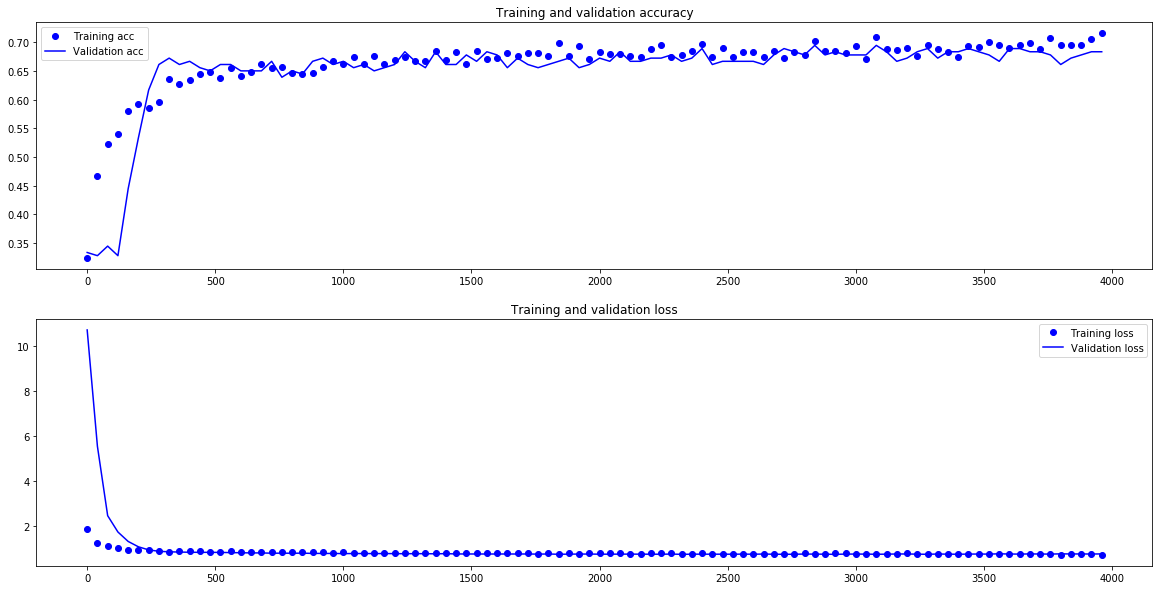

In [68]:
plot_history(history)

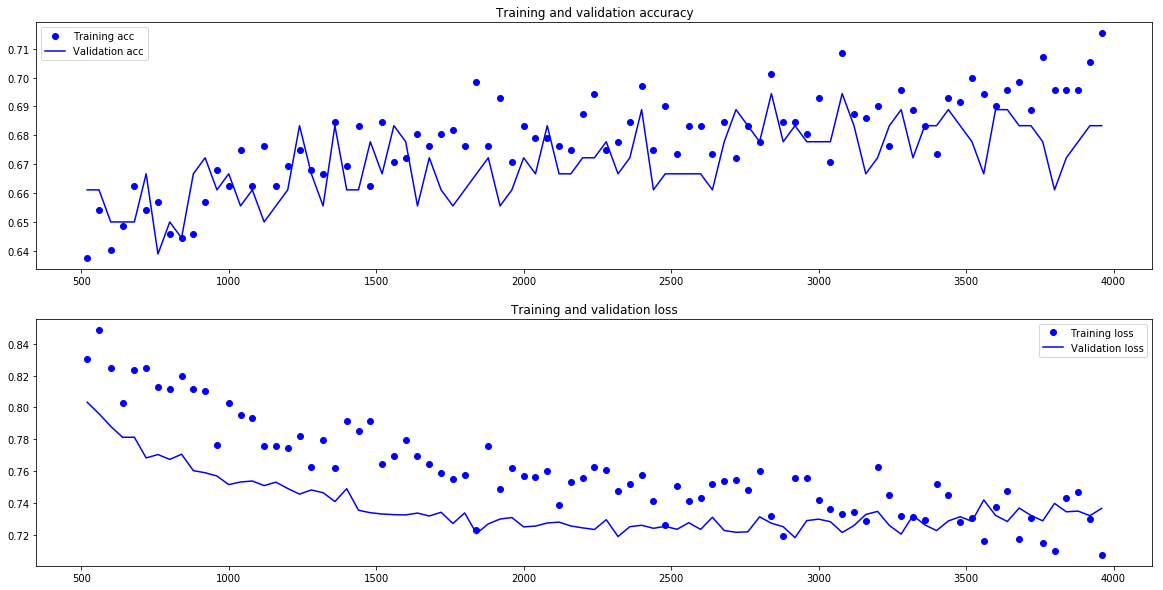

In [118]:
# let's skip the first few samples to have the better resolution for the rest
plot_history(history, init_phase_samples=500)

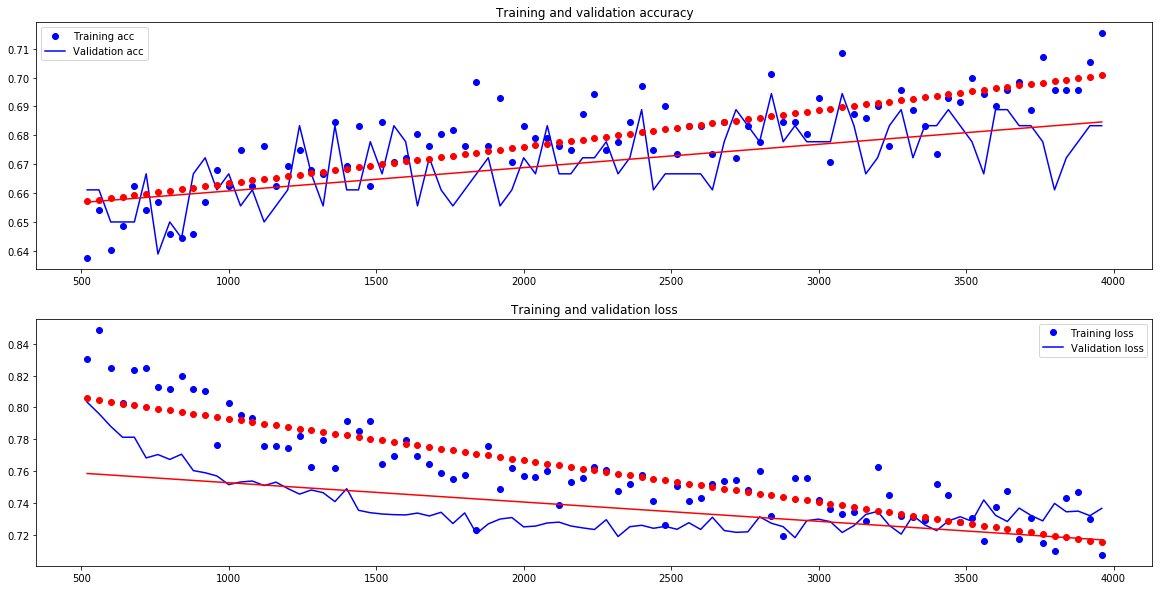

In [135]:
# sometimes it is not so easy if we still have a change, plot a line through the data
plot_history(history, init_phase_samples=500, plot_line=True)

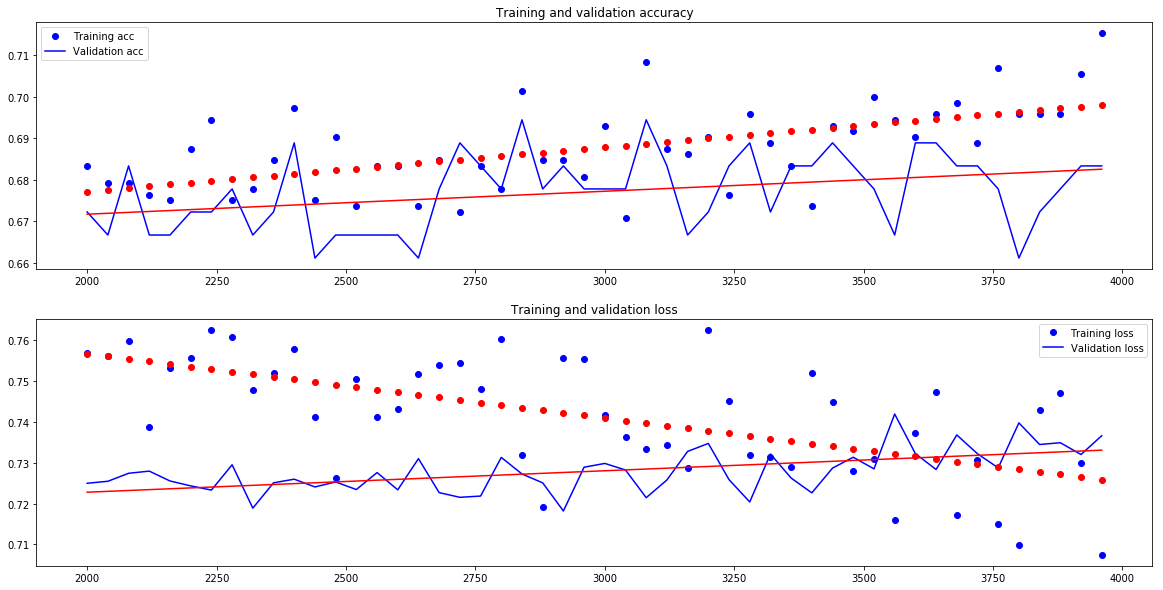

In [132]:
# sometimes it is not so easy if we still have a change, plot a line through the data
plot_history(history, init_phase_samples=2000, plot_line=True)

### The difference was around 88% vs 65%, now we have 71% to 70%, quite a different
### However, from epoch 2000 nothing much is changing and the validation loss is even going up a bit

### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

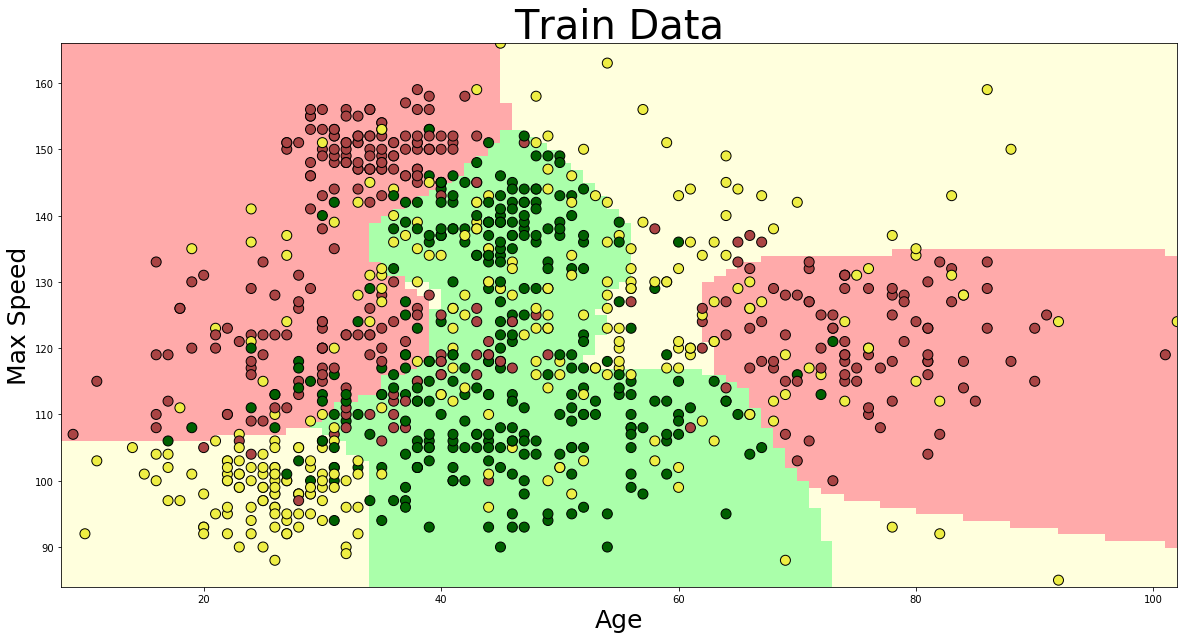

In [29]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

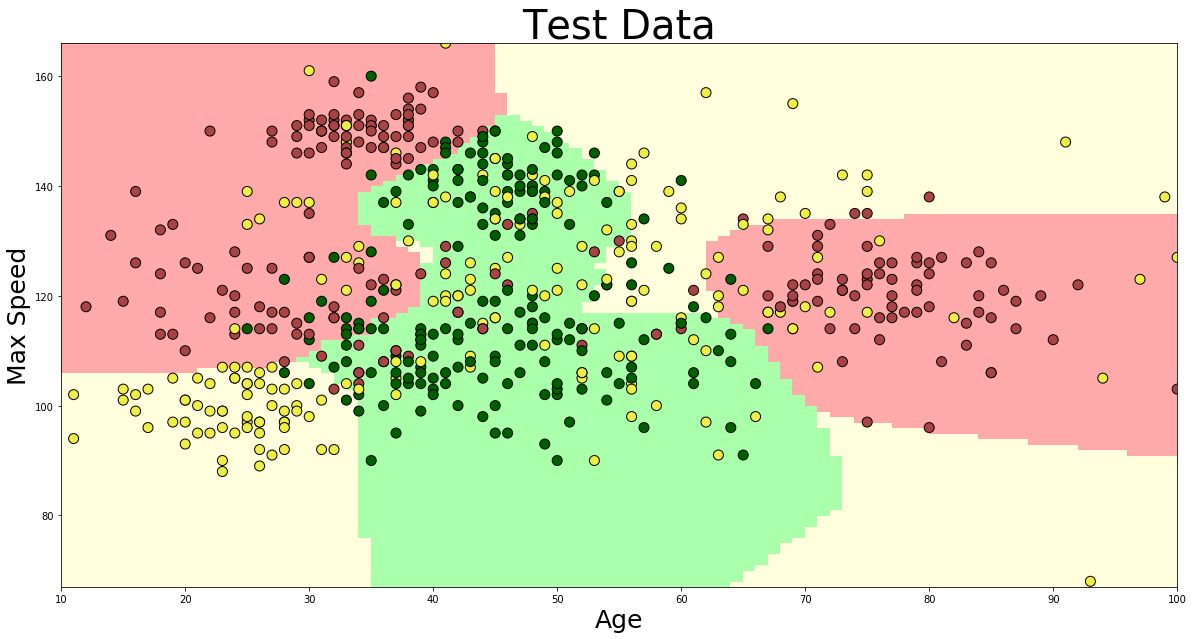

In [30]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data",
                fname='nn-reg.png')

### Decision boundaries look really smooth, though
Let's see how well we are doing for more dimensions with this model

## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [149]:
dropout = 0.6
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(100, name='hidden1', input_dim=3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(100, name='hidden2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
batch_normalization_10 (Batc (None, 100)               400       
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100)               400       
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
__________

### We also limit the number of epochs further to 2000 (because we have seen that after that nothing good is going to happen)

In [150]:
BATCH_SIZE=1000
EPOCHS = 2000

# only if you are running this locally
# !rm -rf ./tf_log
# %time model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

%time history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/2000
720/720 [==============================] - 1s 2ms/step - loss: 1.6585 - acc: 0.3292 - val_loss: 9.6810 - val_acc: 0.3333
Epoch 2/2000
720/720 [==============================] - 0s 21us/step - loss: 1.6531 - acc: 0.3417 - val_loss: 8.1626 - val_acc: 0.3333
Epoch 3/2000
720/720 [==============================] - 0s 17us/step - loss: 1.6591 - acc: 0.3236 - val_loss: 5.7938 - val_acc: 0.3333
Epoch 4/2000
720/720 [==============================] - 0s 17us/step - loss: 1.6514 - acc: 0.3181 - val_loss: 3.7579 - val_acc: 0.3333
Epoch 5/2000
720/720 [==============================] - 0s 17us/step - loss: 1.6206 - acc: 0.3444 - val_loss: 2.3124 - val_acc: 0.4722
Epoch 6/2000
720/720 [==============================] - 0s 25us/step - loss: 1.4213 - acc: 0.3889 - val_loss: 2.1807 - val_acc: 0.3611
Epoch 7/2000
720/720 [==============================] - 0s 18us/step - loss: 1.3790 - acc: 0.3944 - val_loss: 2.8641 - val_acc: 0.3333
Epoch 8/20

Epoch 61/2000
720/720 [==============================] - 0s 19us/step - loss: 0.9339 - acc: 0.6097 - val_loss: 2.2909 - val_acc: 0.4278
Epoch 62/2000
720/720 [==============================] - 0s 18us/step - loss: 0.9089 - acc: 0.6167 - val_loss: 2.2761 - val_acc: 0.4278
Epoch 63/2000
720/720 [==============================] - 0s 19us/step - loss: 0.9314 - acc: 0.5764 - val_loss: 2.2585 - val_acc: 0.4333
Epoch 64/2000
720/720 [==============================] - 0s 18us/step - loss: 0.9193 - acc: 0.6083 - val_loss: 2.2417 - val_acc: 0.4333
Epoch 65/2000
720/720 [==============================] - 0s 18us/step - loss: 0.9146 - acc: 0.6097 - val_loss: 2.2253 - val_acc: 0.4333
Epoch 66/2000
720/720 [==============================] - 0s 19us/step - loss: 0.9405 - acc: 0.5778 - val_loss: 2.2072 - val_acc: 0.4333
Epoch 67/2000
720/720 [==============================] - 0s 24us/step - loss: 0.8828 - acc: 0.6153 - val_loss: 2.1908 - val_acc: 0.4333
Epoch 68/2000
720/720 [=========================

Epoch 122/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8161 - acc: 0.6528 - val_loss: 1.4588 - val_acc: 0.4667
Epoch 123/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8120 - acc: 0.6486 - val_loss: 1.4513 - val_acc: 0.4667
Epoch 124/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8351 - acc: 0.6458 - val_loss: 1.4432 - val_acc: 0.4667
Epoch 125/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8306 - acc: 0.6486 - val_loss: 1.4344 - val_acc: 0.4611
Epoch 126/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8361 - acc: 0.6667 - val_loss: 1.4236 - val_acc: 0.4667
Epoch 127/2000
720/720 [==============================] - 0s 19us/step - loss: 0.8214 - acc: 0.6583 - val_loss: 1.4124 - val_acc: 0.4667
Epoch 128/2000
720/720 [==============================] - 0s 21us/step - loss: 0.8031 - acc: 0.6681 - val_loss: 1.4006 - val_acc: 0.4667
Epoch 129/2000
720/720 [=================

Epoch 182/2000
720/720 [==============================] - 0s 32us/step - loss: 0.7765 - acc: 0.6833 - val_loss: 0.9153 - val_acc: 0.5944
Epoch 183/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7462 - acc: 0.6764 - val_loss: 0.9089 - val_acc: 0.6000
Epoch 184/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7531 - acc: 0.7014 - val_loss: 0.9025 - val_acc: 0.6056
Epoch 185/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7818 - acc: 0.6764 - val_loss: 0.8957 - val_acc: 0.6056
Epoch 186/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7673 - acc: 0.6750 - val_loss: 0.8892 - val_acc: 0.6111
Epoch 187/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7453 - acc: 0.6833 - val_loss: 0.8833 - val_acc: 0.6111
Epoch 188/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7830 - acc: 0.6958 - val_loss: 0.8778 - val_acc: 0.6167
Epoch 189/2000
720/720 [=================

Epoch 242/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7305 - acc: 0.7056 - val_loss: 0.6715 - val_acc: 0.7556
Epoch 243/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7555 - acc: 0.6750 - val_loss: 0.6689 - val_acc: 0.7556
Epoch 244/2000
720/720 [==============================] - 0s 36us/step - loss: 0.7473 - acc: 0.6972 - val_loss: 0.6659 - val_acc: 0.7556
Epoch 245/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7593 - acc: 0.6958 - val_loss: 0.6635 - val_acc: 0.7556
Epoch 246/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7407 - acc: 0.6972 - val_loss: 0.6610 - val_acc: 0.7500
Epoch 247/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7292 - acc: 0.7000 - val_loss: 0.6588 - val_acc: 0.7500
Epoch 248/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7391 - acc: 0.7000 - val_loss: 0.6566 - val_acc: 0.7500
Epoch 249/2000
720/720 [==================

Epoch 302/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7157 - acc: 0.7250 - val_loss: 0.6094 - val_acc: 0.7889
Epoch 303/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7244 - acc: 0.7292 - val_loss: 0.6092 - val_acc: 0.7889
Epoch 304/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7187 - acc: 0.7028 - val_loss: 0.6089 - val_acc: 0.7889
Epoch 305/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6879 - acc: 0.7167 - val_loss: 0.6091 - val_acc: 0.7889
Epoch 306/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7274 - acc: 0.7139 - val_loss: 0.6093 - val_acc: 0.7889
Epoch 307/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6895 - acc: 0.7319 - val_loss: 0.6088 - val_acc: 0.7889
Epoch 308/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7364 - acc: 0.6917 - val_loss: 0.6084 - val_acc: 0.7889
Epoch 309/2000
720/720 [=================

Epoch 362/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7209 - acc: 0.7056 - val_loss: 0.5953 - val_acc: 0.7611
Epoch 363/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7055 - acc: 0.7222 - val_loss: 0.5932 - val_acc: 0.7611
Epoch 364/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6768 - acc: 0.7306 - val_loss: 0.5917 - val_acc: 0.7611
Epoch 365/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6593 - acc: 0.7472 - val_loss: 0.5902 - val_acc: 0.7611
Epoch 366/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6964 - acc: 0.7083 - val_loss: 0.5886 - val_acc: 0.7611
Epoch 367/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6911 - acc: 0.7250 - val_loss: 0.5874 - val_acc: 0.7667
Epoch 368/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7308 - acc: 0.6986 - val_loss: 0.5868 - val_acc: 0.7667
Epoch 369/2000
720/720 [=================

Epoch 422/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6877 - acc: 0.7333 - val_loss: 0.5868 - val_acc: 0.7722
Epoch 423/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7179 - acc: 0.7056 - val_loss: 0.5882 - val_acc: 0.7722
Epoch 424/2000
720/720 [==============================] - 0s 32us/step - loss: 0.6767 - acc: 0.7222 - val_loss: 0.5904 - val_acc: 0.7611
Epoch 425/2000
720/720 [==============================] - 0s 20us/step - loss: 0.6728 - acc: 0.7236 - val_loss: 0.5915 - val_acc: 0.7611
Epoch 426/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7200 - acc: 0.7000 - val_loss: 0.5920 - val_acc: 0.7611
Epoch 427/2000
720/720 [==============================] - 0s 0us/step - loss: 0.7196 - acc: 0.7181 - val_loss: 0.5920 - val_acc: 0.7611
Epoch 428/2000
720/720 [==============================] - 0s 0us/step - loss: 0.6736 - acc: 0.7361 - val_loss: 0.5918 - val_acc: 0.7556
Epoch 429/2000
720/720 [===================

Epoch 482/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6856 - acc: 0.7361 - val_loss: 0.5850 - val_acc: 0.7667
Epoch 483/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6719 - acc: 0.7333 - val_loss: 0.5845 - val_acc: 0.7611
Epoch 484/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6944 - acc: 0.7208 - val_loss: 0.5838 - val_acc: 0.7556
Epoch 485/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6761 - acc: 0.7194 - val_loss: 0.5830 - val_acc: 0.7556
Epoch 486/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6544 - acc: 0.7375 - val_loss: 0.5823 - val_acc: 0.7556
Epoch 487/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6751 - acc: 0.7278 - val_loss: 0.5812 - val_acc: 0.7611
Epoch 488/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6901 - acc: 0.7347 - val_loss: 0.5806 - val_acc: 0.7667
Epoch 489/2000
720/720 [=================

Epoch 542/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6630 - acc: 0.7500 - val_loss: 0.5703 - val_acc: 0.7500
Epoch 543/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6851 - acc: 0.7167 - val_loss: 0.5707 - val_acc: 0.7500
Epoch 544/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6486 - acc: 0.7514 - val_loss: 0.5706 - val_acc: 0.7500
Epoch 545/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6682 - acc: 0.7264 - val_loss: 0.5701 - val_acc: 0.7500
Epoch 546/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6563 - acc: 0.7514 - val_loss: 0.5692 - val_acc: 0.7500
Epoch 547/2000
720/720 [==============================] - 0s 15us/step - loss: 0.6507 - acc: 0.7528 - val_loss: 0.5684 - val_acc: 0.7500
Epoch 548/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6737 - acc: 0.7431 - val_loss: 0.5675 - val_acc: 0.7500
Epoch 549/2000
720/720 [=================

Epoch 602/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6522 - acc: 0.7403 - val_loss: 0.5755 - val_acc: 0.7611
Epoch 603/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6499 - acc: 0.7486 - val_loss: 0.5762 - val_acc: 0.7611
Epoch 604/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6159 - acc: 0.7569 - val_loss: 0.5770 - val_acc: 0.7611
Epoch 605/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6504 - acc: 0.7333 - val_loss: 0.5771 - val_acc: 0.7611
Epoch 606/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6443 - acc: 0.7486 - val_loss: 0.5775 - val_acc: 0.7611
Epoch 607/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6650 - acc: 0.7361 - val_loss: 0.5771 - val_acc: 0.7556
Epoch 608/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6613 - acc: 0.7514 - val_loss: 0.5772 - val_acc: 0.7556
Epoch 609/2000
720/720 [=================

Epoch 662/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6275 - acc: 0.7528 - val_loss: 0.5647 - val_acc: 0.7611
Epoch 663/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6257 - acc: 0.7556 - val_loss: 0.5642 - val_acc: 0.7611
Epoch 664/2000
720/720 [==============================] - 0s 30us/step - loss: 0.6711 - acc: 0.7361 - val_loss: 0.5634 - val_acc: 0.7611
Epoch 665/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6367 - acc: 0.7417 - val_loss: 0.5624 - val_acc: 0.7611
Epoch 666/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6233 - acc: 0.7556 - val_loss: 0.5620 - val_acc: 0.7611
Epoch 667/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6414 - acc: 0.7444 - val_loss: 0.5610 - val_acc: 0.7611
Epoch 668/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6551 - acc: 0.7528 - val_loss: 0.5596 - val_acc: 0.7611
Epoch 669/2000
720/720 [=================

Epoch 722/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6239 - acc: 0.7500 - val_loss: 0.5573 - val_acc: 0.7667
Epoch 723/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6345 - acc: 0.7556 - val_loss: 0.5556 - val_acc: 0.7667
Epoch 724/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6542 - acc: 0.7542 - val_loss: 0.5537 - val_acc: 0.7667
Epoch 725/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6481 - acc: 0.7514 - val_loss: 0.5515 - val_acc: 0.7722
Epoch 726/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6485 - acc: 0.7417 - val_loss: 0.5492 - val_acc: 0.7778
Epoch 727/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6346 - acc: 0.7556 - val_loss: 0.5480 - val_acc: 0.7778
Epoch 728/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6537 - acc: 0.7458 - val_loss: 0.5471 - val_acc: 0.7778
Epoch 729/2000
720/720 [=================

Epoch 782/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6468 - acc: 0.7250 - val_loss: 0.5528 - val_acc: 0.7611
Epoch 783/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6149 - acc: 0.7583 - val_loss: 0.5533 - val_acc: 0.7611
Epoch 784/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6191 - acc: 0.7528 - val_loss: 0.5534 - val_acc: 0.7611
Epoch 785/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6513 - acc: 0.7444 - val_loss: 0.5524 - val_acc: 0.7667
Epoch 786/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6377 - acc: 0.7708 - val_loss: 0.5510 - val_acc: 0.7722
Epoch 787/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6373 - acc: 0.7486 - val_loss: 0.5500 - val_acc: 0.7722
Epoch 788/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6206 - acc: 0.7542 - val_loss: 0.5488 - val_acc: 0.7778
Epoch 789/2000
720/720 [=================

Epoch 842/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6270 - acc: 0.7431 - val_loss: 0.5548 - val_acc: 0.7778
Epoch 843/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6199 - acc: 0.7639 - val_loss: 0.5543 - val_acc: 0.7778
Epoch 844/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6222 - acc: 0.7597 - val_loss: 0.5537 - val_acc: 0.7778
Epoch 845/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6103 - acc: 0.7667 - val_loss: 0.5536 - val_acc: 0.7778
Epoch 846/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6134 - acc: 0.7708 - val_loss: 0.5536 - val_acc: 0.7778
Epoch 847/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6273 - acc: 0.7542 - val_loss: 0.5531 - val_acc: 0.7778
Epoch 848/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6188 - acc: 0.7569 - val_loss: 0.5527 - val_acc: 0.7778
Epoch 849/2000
720/720 [=================

Epoch 902/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6240 - acc: 0.7597 - val_loss: 0.5515 - val_acc: 0.7667
Epoch 903/2000
720/720 [==============================] - 0s 29us/step - loss: 0.6306 - acc: 0.7611 - val_loss: 0.5526 - val_acc: 0.7667
Epoch 904/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6111 - acc: 0.7694 - val_loss: 0.5535 - val_acc: 0.7667
Epoch 905/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6467 - acc: 0.7472 - val_loss: 0.5544 - val_acc: 0.7667
Epoch 906/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5943 - acc: 0.7694 - val_loss: 0.5542 - val_acc: 0.7667
Epoch 907/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6087 - acc: 0.7514 - val_loss: 0.5544 - val_acc: 0.7611
Epoch 908/2000
720/720 [==============================] - 0s 29us/step - loss: 0.6399 - acc: 0.7542 - val_loss: 0.5541 - val_acc: 0.7611
Epoch 909/2000
720/720 [=================

Epoch 962/2000
720/720 [==============================] - 0s 15us/step - loss: 0.5914 - acc: 0.7681 - val_loss: 0.5317 - val_acc: 0.7889
Epoch 963/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5821 - acc: 0.7764 - val_loss: 0.5320 - val_acc: 0.7889
Epoch 964/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6089 - acc: 0.7653 - val_loss: 0.5329 - val_acc: 0.7833
Epoch 965/2000
720/720 [==============================] - 0s 0us/step - loss: 0.6037 - acc: 0.7708 - val_loss: 0.5340 - val_acc: 0.7833
Epoch 966/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5904 - acc: 0.7708 - val_loss: 0.5356 - val_acc: 0.7833
Epoch 967/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6071 - acc: 0.7556 - val_loss: 0.5371 - val_acc: 0.7833
Epoch 968/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6040 - acc: 0.7667 - val_loss: 0.5388 - val_acc: 0.7833
Epoch 969/2000
720/720 [==================

Epoch 1022/2000
720/720 [==============================] - 0s 36us/step - loss: 0.5941 - acc: 0.7653 - val_loss: 0.5354 - val_acc: 0.7667
Epoch 1023/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6076 - acc: 0.7736 - val_loss: 0.5353 - val_acc: 0.7667
Epoch 1024/2000
720/720 [==============================] - 0s 8us/step - loss: 0.6025 - acc: 0.7694 - val_loss: 0.5355 - val_acc: 0.7667
Epoch 1025/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5755 - acc: 0.7847 - val_loss: 0.5352 - val_acc: 0.7667
Epoch 1026/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6254 - acc: 0.7611 - val_loss: 0.5358 - val_acc: 0.7667
Epoch 1027/2000
720/720 [==============================] - 0s 16us/step - loss: 0.6022 - acc: 0.7681 - val_loss: 0.5362 - val_acc: 0.7611
Epoch 1028/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6305 - acc: 0.7514 - val_loss: 0.5363 - val_acc: 0.7611
Epoch 1029/2000
720/720 [==========

Epoch 1082/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5935 - acc: 0.7792 - val_loss: 0.5311 - val_acc: 0.7833
Epoch 1083/2000
720/720 [==============================] - 0s 26us/step - loss: 0.5973 - acc: 0.7667 - val_loss: 0.5311 - val_acc: 0.7833
Epoch 1084/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5875 - acc: 0.7750 - val_loss: 0.5312 - val_acc: 0.7833
Epoch 1085/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6007 - acc: 0.7611 - val_loss: 0.5317 - val_acc: 0.7889
Epoch 1086/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5650 - acc: 0.7639 - val_loss: 0.5323 - val_acc: 0.7833
Epoch 1087/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6269 - acc: 0.7514 - val_loss: 0.5328 - val_acc: 0.7833
Epoch 1088/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6070 - acc: 0.7611 - val_loss: 0.5334 - val_acc: 0.7833
Epoch 1089/2000
720/720 [=========

Epoch 1142/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5731 - acc: 0.7861 - val_loss: 0.5388 - val_acc: 0.7722
Epoch 1143/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6043 - acc: 0.7708 - val_loss: 0.5374 - val_acc: 0.7722
Epoch 1144/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5848 - acc: 0.7681 - val_loss: 0.5363 - val_acc: 0.7722
Epoch 1145/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5894 - acc: 0.7653 - val_loss: 0.5352 - val_acc: 0.7778
Epoch 1146/2000
720/720 [==============================] - 0s 35us/step - loss: 0.5810 - acc: 0.7861 - val_loss: 0.5337 - val_acc: 0.7778
Epoch 1147/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5954 - acc: 0.7694 - val_loss: 0.5333 - val_acc: 0.7778
Epoch 1148/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6231 - acc: 0.7653 - val_loss: 0.5335 - val_acc: 0.7722
Epoch 1149/2000
720/720 [=========

Epoch 1202/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5977 - acc: 0.7639 - val_loss: 0.5547 - val_acc: 0.7556
Epoch 1203/2000
720/720 [==============================] - 0s 16us/step - loss: 0.5640 - acc: 0.7778 - val_loss: 0.5530 - val_acc: 0.7556
Epoch 1204/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5893 - acc: 0.7639 - val_loss: 0.5513 - val_acc: 0.7556
Epoch 1205/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5887 - acc: 0.7625 - val_loss: 0.5495 - val_acc: 0.7500
Epoch 1206/2000
720/720 [==============================] - 0s 1us/step - loss: 0.5723 - acc: 0.7514 - val_loss: 0.5488 - val_acc: 0.7500
Epoch 1207/2000
720/720 [==============================] - 0s 38us/step - loss: 0.5994 - acc: 0.7764 - val_loss: 0.5473 - val_acc: 0.7500
Epoch 1208/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5872 - acc: 0.7694 - val_loss: 0.5462 - val_acc: 0.7556
Epoch 1209/2000
720/720 [==========

Epoch 1262/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5770 - acc: 0.7639 - val_loss: 0.5471 - val_acc: 0.7611
Epoch 1263/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5678 - acc: 0.7764 - val_loss: 0.5470 - val_acc: 0.7611
Epoch 1264/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5898 - acc: 0.7806 - val_loss: 0.5472 - val_acc: 0.7667
Epoch 1265/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5909 - acc: 0.7750 - val_loss: 0.5473 - val_acc: 0.7667
Epoch 1266/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5844 - acc: 0.7917 - val_loss: 0.5473 - val_acc: 0.7611
Epoch 1267/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5908 - acc: 0.7736 - val_loss: 0.5471 - val_acc: 0.7556
Epoch 1268/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5898 - acc: 0.7583 - val_loss: 0.5470 - val_acc: 0.7556
Epoch 1269/2000
720/720 [=========

Epoch 1322/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5641 - acc: 0.7708 - val_loss: 0.5299 - val_acc: 0.7722
Epoch 1323/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5767 - acc: 0.7667 - val_loss: 0.5314 - val_acc: 0.7722
Epoch 1324/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5793 - acc: 0.7833 - val_loss: 0.5325 - val_acc: 0.7722
Epoch 1325/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5792 - acc: 0.7806 - val_loss: 0.5339 - val_acc: 0.7722
Epoch 1326/2000
720/720 [==============================] - 0s 29us/step - loss: 0.5870 - acc: 0.7667 - val_loss: 0.5352 - val_acc: 0.7722
Epoch 1327/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5683 - acc: 0.7806 - val_loss: 0.5357 - val_acc: 0.7667
Epoch 1328/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5790 - acc: 0.7681 - val_loss: 0.5358 - val_acc: 0.7611
Epoch 1329/2000
720/720 [=========

Epoch 1382/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5623 - acc: 0.7847 - val_loss: 0.5459 - val_acc: 0.7556
Epoch 1383/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5489 - acc: 0.7944 - val_loss: 0.5463 - val_acc: 0.7556
Epoch 1384/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5496 - acc: 0.8000 - val_loss: 0.5468 - val_acc: 0.7556
Epoch 1385/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5579 - acc: 0.7792 - val_loss: 0.5468 - val_acc: 0.7556
Epoch 1386/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5845 - acc: 0.7792 - val_loss: 0.5464 - val_acc: 0.7500
Epoch 1387/2000
720/720 [==============================] - 0s 27us/step - loss: 0.5687 - acc: 0.7778 - val_loss: 0.5455 - val_acc: 0.7500
Epoch 1388/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6031 - acc: 0.7736 - val_loss: 0.5454 - val_acc: 0.7500
Epoch 1389/2000
720/720 [=========

Epoch 1442/2000
720/720 [==============================] - 0s 29us/step - loss: 0.5962 - acc: 0.7750 - val_loss: 0.5575 - val_acc: 0.7389
Epoch 1443/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5741 - acc: 0.7847 - val_loss: 0.5586 - val_acc: 0.7444
Epoch 1444/2000
720/720 [==============================] - 0s 25us/step - loss: 0.5888 - acc: 0.7861 - val_loss: 0.5584 - val_acc: 0.7444
Epoch 1445/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5650 - acc: 0.7889 - val_loss: 0.5579 - val_acc: 0.7444
Epoch 1446/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5780 - acc: 0.7722 - val_loss: 0.5582 - val_acc: 0.7444
Epoch 1447/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5559 - acc: 0.7806 - val_loss: 0.5576 - val_acc: 0.7444
Epoch 1448/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5763 - acc: 0.7694 - val_loss: 0.5571 - val_acc: 0.7444
Epoch 1449/2000
720/720 [=========

Epoch 1502/2000
720/720 [==============================] - 0s 29us/step - loss: 0.5422 - acc: 0.7847 - val_loss: 0.5498 - val_acc: 0.7611
Epoch 1503/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5709 - acc: 0.7847 - val_loss: 0.5485 - val_acc: 0.7667
Epoch 1504/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5419 - acc: 0.7833 - val_loss: 0.5470 - val_acc: 0.7667
Epoch 1505/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5700 - acc: 0.7722 - val_loss: 0.5458 - val_acc: 0.7667
Epoch 1506/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5543 - acc: 0.7917 - val_loss: 0.5441 - val_acc: 0.7667
Epoch 1507/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5636 - acc: 0.8000 - val_loss: 0.5425 - val_acc: 0.7667
Epoch 1508/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5711 - acc: 0.7764 - val_loss: 0.5421 - val_acc: 0.7667
Epoch 1509/2000
720/720 [=========

Epoch 1562/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5924 - acc: 0.7764 - val_loss: 0.5599 - val_acc: 0.7444
Epoch 1563/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5662 - acc: 0.7819 - val_loss: 0.5597 - val_acc: 0.7444
Epoch 1564/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5504 - acc: 0.7944 - val_loss: 0.5598 - val_acc: 0.7444
Epoch 1565/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5675 - acc: 0.7944 - val_loss: 0.5606 - val_acc: 0.7444
Epoch 1566/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6034 - acc: 0.7722 - val_loss: 0.5621 - val_acc: 0.7500
Epoch 1567/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5737 - acc: 0.7806 - val_loss: 0.5638 - val_acc: 0.7500
Epoch 1568/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5445 - acc: 0.8042 - val_loss: 0.5654 - val_acc: 0.7500
Epoch 1569/2000
720/720 [=========

Epoch 1622/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5654 - acc: 0.7806 - val_loss: 0.5472 - val_acc: 0.7500
Epoch 1623/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5393 - acc: 0.7875 - val_loss: 0.5440 - val_acc: 0.7500
Epoch 1624/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5526 - acc: 0.7889 - val_loss: 0.5423 - val_acc: 0.7500
Epoch 1625/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5376 - acc: 0.7958 - val_loss: 0.5405 - val_acc: 0.7556
Epoch 1626/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5236 - acc: 0.7861 - val_loss: 0.5398 - val_acc: 0.7611
Epoch 1627/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5456 - acc: 0.7917 - val_loss: 0.5401 - val_acc: 0.7611
Epoch 1628/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5705 - acc: 0.7806 - val_loss: 0.5399 - val_acc: 0.7667
Epoch 1629/2000
720/720 [=========

Epoch 1682/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5719 - acc: 0.7861 - val_loss: 0.5468 - val_acc: 0.7778
Epoch 1683/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5683 - acc: 0.7889 - val_loss: 0.5490 - val_acc: 0.7722
Epoch 1684/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5612 - acc: 0.7736 - val_loss: 0.5512 - val_acc: 0.7667
Epoch 1685/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5669 - acc: 0.7875 - val_loss: 0.5532 - val_acc: 0.7667
Epoch 1686/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5711 - acc: 0.7931 - val_loss: 0.5548 - val_acc: 0.7667
Epoch 1687/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5470 - acc: 0.7917 - val_loss: 0.5560 - val_acc: 0.7667
Epoch 1688/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5372 - acc: 0.8014 - val_loss: 0.5566 - val_acc: 0.7667
Epoch 1689/2000
720/720 [=========

Epoch 1742/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5585 - acc: 0.7806 - val_loss: 0.5705 - val_acc: 0.7444
Epoch 1743/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5798 - acc: 0.7833 - val_loss: 0.5702 - val_acc: 0.7500
Epoch 1744/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5422 - acc: 0.7972 - val_loss: 0.5699 - val_acc: 0.7500
Epoch 1745/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5588 - acc: 0.7847 - val_loss: 0.5703 - val_acc: 0.7444
Epoch 1746/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5413 - acc: 0.7917 - val_loss: 0.5703 - val_acc: 0.7500
Epoch 1747/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5323 - acc: 0.8014 - val_loss: 0.5695 - val_acc: 0.7500
Epoch 1748/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5399 - acc: 0.7889 - val_loss: 0.5677 - val_acc: 0.7500
Epoch 1749/2000
720/720 [=========

Epoch 1802/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5770 - acc: 0.7736 - val_loss: 0.5343 - val_acc: 0.7944
Epoch 1803/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5445 - acc: 0.7917 - val_loss: 0.5337 - val_acc: 0.8000
Epoch 1804/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5528 - acc: 0.7819 - val_loss: 0.5332 - val_acc: 0.8056
Epoch 1805/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5635 - acc: 0.7889 - val_loss: 0.5331 - val_acc: 0.8056
Epoch 1806/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5631 - acc: 0.7972 - val_loss: 0.5323 - val_acc: 0.7944
Epoch 1807/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5614 - acc: 0.7806 - val_loss: 0.5322 - val_acc: 0.7944
Epoch 1808/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5498 - acc: 0.7819 - val_loss: 0.5322 - val_acc: 0.7944
Epoch 1809/2000
720/720 [=========

Epoch 1862/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5551 - acc: 0.7833 - val_loss: 0.5467 - val_acc: 0.7778
Epoch 1863/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5634 - acc: 0.7750 - val_loss: 0.5457 - val_acc: 0.7722
Epoch 1864/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5366 - acc: 0.7875 - val_loss: 0.5449 - val_acc: 0.7722
Epoch 1865/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5569 - acc: 0.7903 - val_loss: 0.5441 - val_acc: 0.7722
Epoch 1866/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5766 - acc: 0.7681 - val_loss: 0.5432 - val_acc: 0.7722
Epoch 1867/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5595 - acc: 0.7722 - val_loss: 0.5420 - val_acc: 0.7778
Epoch 1868/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5391 - acc: 0.7903 - val_loss: 0.5412 - val_acc: 0.7778
Epoch 1869/2000
720/720 [=========

Epoch 1922/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5796 - acc: 0.7833 - val_loss: 0.5442 - val_acc: 0.7889
Epoch 1923/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5460 - acc: 0.7986 - val_loss: 0.5447 - val_acc: 0.7889
Epoch 1924/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5545 - acc: 0.7931 - val_loss: 0.5458 - val_acc: 0.7889
Epoch 1925/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5409 - acc: 0.7986 - val_loss: 0.5469 - val_acc: 0.7889
Epoch 1926/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5573 - acc: 0.7819 - val_loss: 0.5489 - val_acc: 0.7889
Epoch 1927/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5569 - acc: 0.7861 - val_loss: 0.5510 - val_acc: 0.7833
Epoch 1928/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5447 - acc: 0.7931 - val_loss: 0.5530 - val_acc: 0.7778
Epoch 1929/2000
720/720 [=========

Epoch 1982/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5727 - acc: 0.7792 - val_loss: 0.5500 - val_acc: 0.7667
Epoch 1983/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5617 - acc: 0.7778 - val_loss: 0.5506 - val_acc: 0.7667
Epoch 1984/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5789 - acc: 0.7847 - val_loss: 0.5509 - val_acc: 0.7722
Epoch 1985/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5328 - acc: 0.8028 - val_loss: 0.5517 - val_acc: 0.7722
Epoch 1986/2000
720/720 [==============================] - 0s 35us/step - loss: 0.5331 - acc: 0.8014 - val_loss: 0.5519 - val_acc: 0.7722
Epoch 1987/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5362 - acc: 0.8014 - val_loss: 0.5518 - val_acc: 0.7722
Epoch 1988/2000
720/720 [==============================] - 0s 25us/step - loss: 0.5287 - acc: 0.8000 - val_loss: 0.5510 - val_acc: 0.7722
Epoch 1989/2000
720/720 [=========

In [151]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 7us/step


(0.48023340106010437, 0.8133333325386047)

In [152]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 7us/step


(0.5219466090202332, 0.7933333516120911)

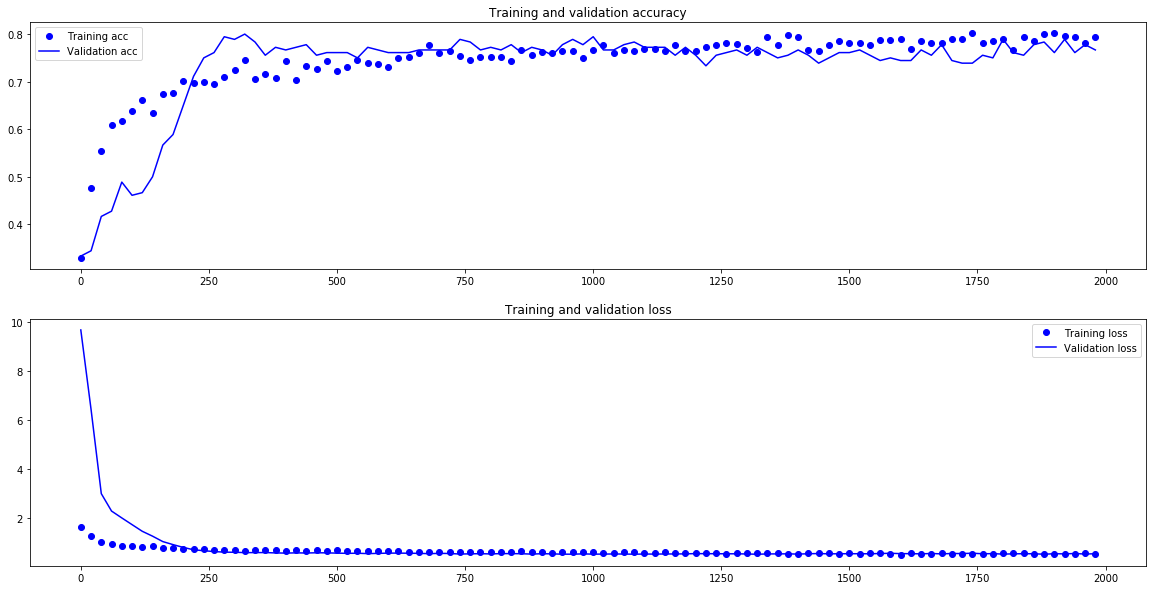

In [153]:
plot_history(history)

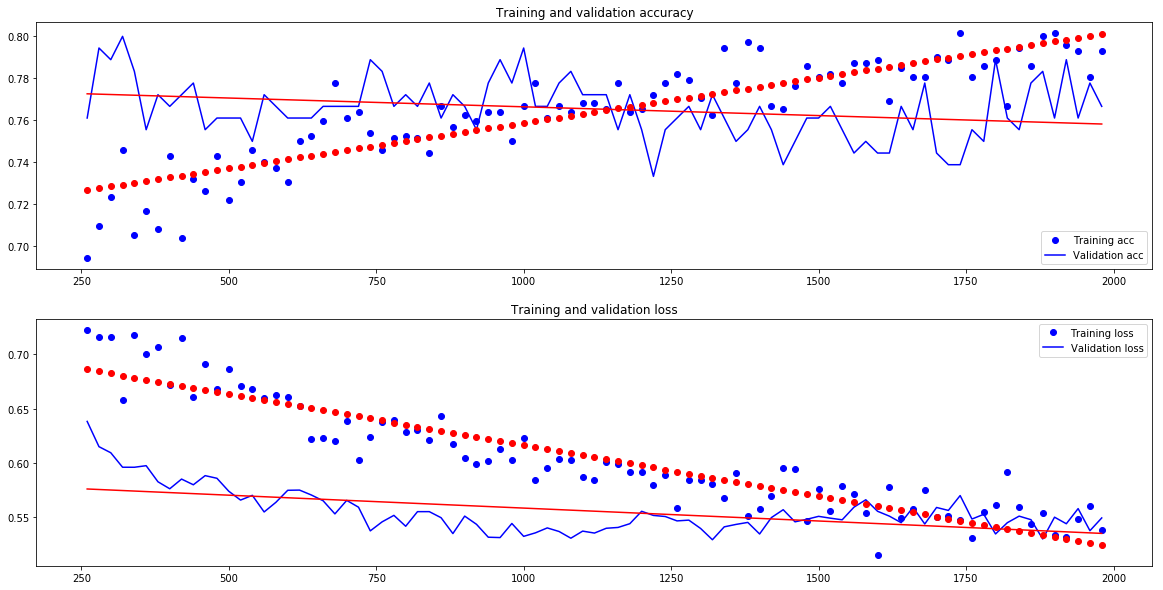

In [154]:
plot_history(history, init_phase_samples=250, plot_line=True)

### Scores around 80% look good now, there might even be a bit more potential here, but we are not going after a final percent here

## We now seem to have a decent model, so we save it for the next steps

In [155]:
model.save('insurance.hdf5')

In [157]:
# the model has a decent size as we only have a little more than 10.000 parameters
!ls -l insurance.hdf5

total 6320
-rw-r--r-- 1 olive 197609    9293 Aug  8 10:59 0-generate.ipynb
drwxr-xr-x 1 olive 197609       0 Aug  8 10:58 data
drwxr-xr-x 1 olive 197609       0 Aug  8 12:01 figures
-rw-r--r-- 1 olive 197609  179808 Aug  9 12:10 insurance.hdf5
-rw-r--r-- 1 olive 197609   26822 Aug  9 10:27 insurance-customers-1500.csv
-rw-r--r-- 1 olive 197609  621648 Aug  8 11:52 U3-M1-example.ipynb
-rw-r--r-- 1 olive 197609 3620457 Aug  9 10:31 U3-M2-nn-intro.ipynb
-rw-r--r-- 1 olive 197609 2002409 Aug  9 12:13 U3-M3-nn-no-bullshit.ipynb
